In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq

## 1. Denver monthly listing,  sells and mean house price

In [3]:
#read the denver listing dates
listData = pd.read_csv('data/denver_listing_dates.csv')
listData['sale_month'] = listData.sale_date.apply(lambda x: str(x)[:-3])
listData['list_month'] = listData.list_date.apply(lambda x: str(x)[:-3])
#listData['sale_date'] = pd.to_datetime(listData['sale_date'],format='%Y-%m-%d')
#listData['list_date'] = pd.to_datetime(listData['list_date'],format='%Y-%m-%d')
listMonth = listData.groupby(['list_month']).agg({"property_id":"count"}).reset_index().iloc[:-1,:]
saleMonth = listData.groupby(['sale_month']).agg({"property_id":"count", "sale_price":"mean"}).reset_index().iloc[1:-2,:]

In [4]:
monthData = pd.merge(saleMonth,listMonth, left_on='sale_month',right_on='list_month')
monthData = monthData.rename(columns={"sale_month":"month","property_id_x":"count_sale", "property_id_y":"count_list","sale_price":"mean_price"})
monthData = monthData.drop(['list_month'],axis=1)
monthData#month from 2016-03 to 2020-09, 55 months in total

,month,count_sale,mean_price,count_list
0,2016-03,5259,392825.600494,12926
1,2016-04,5571,403625.623586,10692
2,2016-05,6340,415779.824132,9405
3,2016-06,6941,427446.501945,9635
4,2016-07,6476,418647.276714,8318
5,2016-08,6686,410690.159438,7864
6,2016-09,6218,402149.781923,7148
7,2016-10,5719,402886.176779,5559
8,2016-11,5421,407862.914960,4179
9,2016-12,5317,404484.769607,2939


Text(0.5, 1.0, 'Trends in sell house counts each month in Denver')

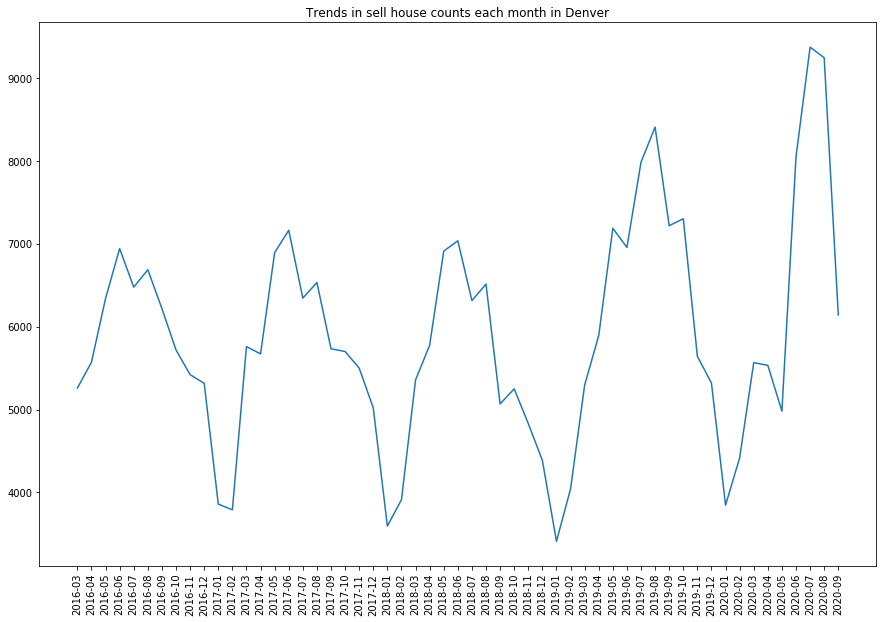

In [4]:
plt.figure(figsize=(15, 10))
plt.plot(monthData['month'],monthData['count_sale'])
plt.xticks(rotation=90)
plt.title('Trends in sell house counts each month in Denver')

Text(0.5, 1.0, 'Trends in house price each month in Denver')

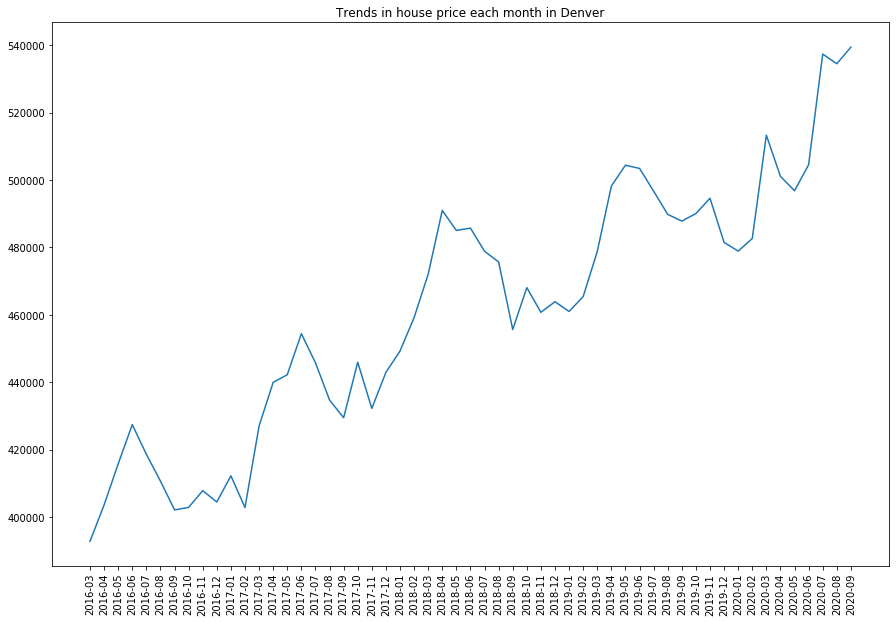

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(monthData['month'],monthData['mean_price'])
plt.xticks(rotation=90)
plt.title('Trends in house price each month in Denver')

Text(0.5, 1.0, 'Trends in house newlist count each month in Denver')

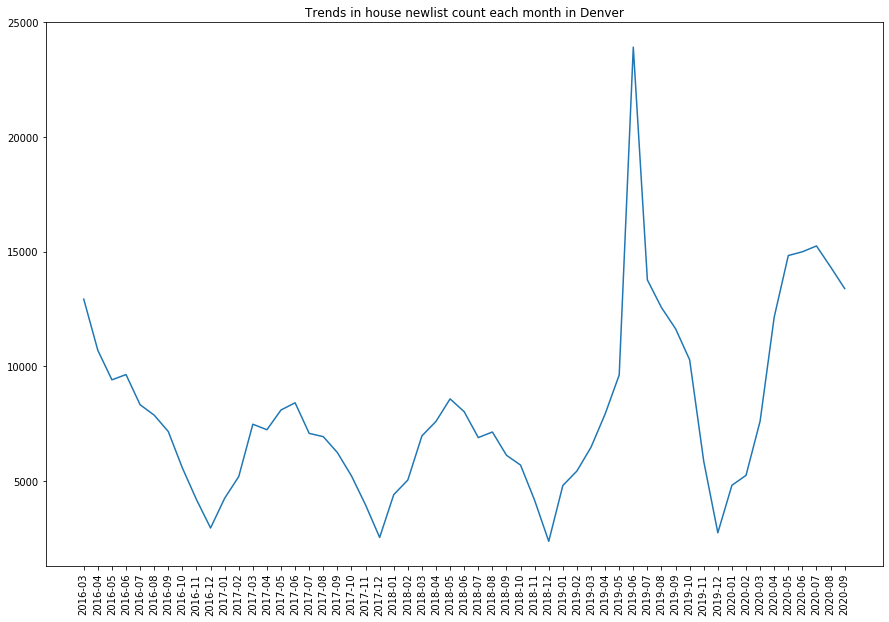

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(monthData['month'],monthData['count_list'])
plt.xticks(rotation=90)
plt.title('Trends in house newlist count each month in Denver')

The plots show that the monthly house selling number, the mean trade price, and the new listed house number in Denver have a strong periodicity. These are three targets we want to predict using google trends data in today's model.

## 2. Google trends data

### 2.1 General used search terms from house buyers and sellers 

The house related search terms are acquired from Rex company. The buyer and seller datasets give us terms that house buyers and sellers would likely to search in google, along with their impressions, which means how many ads are exposed to people who searched the term, and also the interactions, the conversion rates. Since there are too many terms at head, we just use those with most impressions. It is assumed that terms bringing large exposure to ads have a larger effect on the house market. For buyers' terms, we use the first 20 keywords that counts for over 89% percent of total impressions. For sellers' terms, we use the first 30 keywords that counts for over 70% percent of total impressions.

Further, we exclude the keywords including obvious locations not in Denver, and delete phrases with same words(that is because word sequence does not impact the google trends outcome).

Last, when we get search terms, we acquire the monthly google trends data in Colorado from api. All trends for each term are normalized from 0 to 100 scale.

This idea is inspired by the paper, Wu, Lynn and Brynjolfsson, Erik, The Future of Prediction: How Google Searches Foreshadow Housing Prices and Sales (August 30, 2013){https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2022293}. Google trends data is useful in house market prediction for two aspects. For one thing, the sellers term predict the newly listed houses number. For another, both the sellers term and buyers term predict the house price and sales number. The paper predicts wide house index, like the house price index(HPI), however, we will focus on a more specific district here.

In [7]:
# set up google trends api
pytrends = TrendReq(hl='en-US', tz=300)
grouper = pd.Grouper(level='date', freq='M')

In [8]:
def get_keyword_to_time_series(keywords,geo='US-CO'):
    keyword_to_time_series = {}
    for keyword in keywords:
        print(keyword)
        pytrends.build_payload([keyword], cat=0, timeframe='2016-03-01 2020-09-30', geo=geo)
        pytrends_df = pytrends.interest_over_time()
        if len(pytrends_df)!=0: 
            pytrends_monthly_df = pytrends_df.groupby(grouper)[keyword].mean().reset_index()
            time_series = np.array(pytrends_monthly_df[keyword])
            keyword_to_time_series[keyword] = time_series
    return keyword_to_time_series

In [9]:
#load buyer search terms and seller search terms
buyer_df = pd.read_csv('data/buyer_keyword_report.csv')
seller_df = pd.read_csv('data/seller_keyword_report.csv')
def convert_to_int(s):
    return int(''.join(x for x in s if x.isdigit()))
buyer_df['Impr.'] = buyer_df['Impr.'].apply(convert_to_int)
seller_df['Impr.'] = seller_df['Impr.'].apply(convert_to_int)

In [10]:
display(buyer_df.head())
display(seller_df.head())

,Keyword,Match type,Impr.,Interactions,Interaction rate,Conv. rate
0,[buy 4 Bedroom Home In Windermere Fl],Exact match,0,0,--,0.00%
1,[buy 2 Bedroom Single House In Volusia County],Exact match,0,0,--,0.00%
2,[4 Bedroom Condo In Chicago for sale],Exact match,0,0,--,0.00%
3,[3 Bedroom Home In Canyon Country Ca for sale],Exact match,0,0,--,0.00%
4,[buy 1 Bedroom House In Pagosa Springs Co],Exact match,0,0,--,0.00%


,Keyword,Match type,Impr.,Interactions,Interaction rate,Conv. rate
0,"""what is the value of my home""",Phrase match,3212,476,14.82%,16.81%
1,+online +home +appraisal,Broad match,289,40,13.84%,8.75%
2,+trelora +agent,Broad match,0,0,--,0.00%
3,+market +value +of +my +house,Broad match,493,59,11.97%,10.17%
4,+how +much +would +my +house +be +worth,Broad match,158,23,14.56%,4.35%


In [11]:
buyer_word_sorted = buyer_df.groupby('Keyword')['Impr.'].max().sort_values(ascending=False)
seller_word_sorted = seller_df.groupby('Keyword')['Impr.'].max().sort_values(ascending=False)
#use max method because exact match and phrase match are included in the broad match

In [12]:
print(buyer_word_sorted.values.cumsum()[:20]/sum(buyer_word_sorted.values))
print(seller_word_sorted.values.cumsum()[:50]/sum(seller_word_sorted.values))

[0.38763931 0.5282684  0.64087642 0.7515058  0.77199057 0.79183519
 0.81045771 0.82168941 0.83111706 0.83978817 0.84828469 0.8545116
 0.86065121 0.86638345 0.87176652 0.87714959 0.88186342 0.88651904
 0.89105828 0.89542293]
[0.05739425 0.11008985 0.15021025 0.18990691 0.22285589 0.25429514
 0.28122773 0.30752869 0.33334814 0.35519595 0.37585248 0.39493141
 0.41309073 0.42926774 0.44538579 0.46143829 0.47625664 0.49038869
 0.50368103 0.51657775 0.5279475  0.53886753 0.54974723 0.56035077
 0.57083718 0.58111686 0.59021883 0.59894166 0.60747503 0.61599968
 0.6243461  0.63199827 0.63923524 0.64645339 0.65338861 0.66021853
 0.66692414 0.67325624 0.67927768 0.68477822 0.69024638 0.69564066
 0.70098897 0.70619591 0.71129464 0.71624152 0.7210769  0.72579883
 0.73045308 0.73492581]


Text(0, 0.5, 'cumsum percentages')

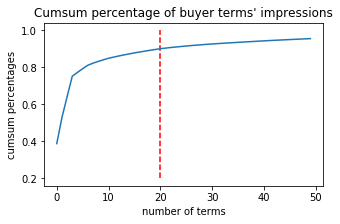

In [13]:
plt.figure(figsize=(5, 3))
plt.plot(buyer_word_sorted.values.cumsum()[:50]/sum(buyer_word_sorted.values))
plt.title("Cumsum percentage of buyer terms' impressions")
plt.vlines(x=20,ymin=0.2, ymax=1,color='red',linestyles='dashed')
plt.xlabel('number of terms')
plt.ylabel('cumsum percentages')
#Use the first 10 search words that counts for over 89% percent of total impressions

Text(0.5, 1.0, 'First 20 Impression buyer keywords')

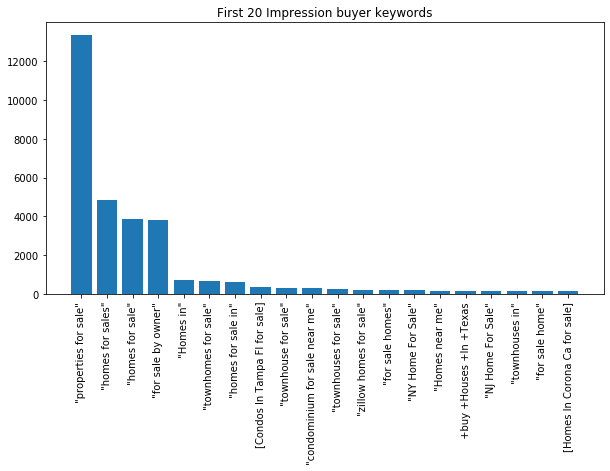

In [14]:
plt.figure(figsize=(10, 5))
num = 20
plt.bar(height =buyer_word_sorted.iloc[:num].values, x= buyer_word_sorted.iloc[:num].index)
plt.xticks(rotation=90)
plt.title('First {} Impression buyer keywords'.format(num))


Text(0, 0.5, 'cumsum percentages')

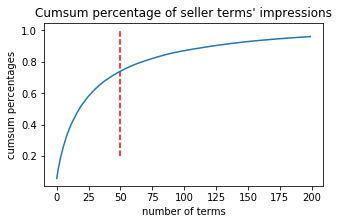

In [15]:
plt.figure(figsize=(5, 3))
plt.plot(seller_word_sorted.values.cumsum()[:200]/sum(seller_word_sorted.values))
plt.title("Cumsum percentage of seller terms' impressions")
plt.vlines(x=50,ymin=0.2, ymax=1,color='red',linestyles='dashed')
plt.xlabel('number of terms')
plt.ylabel('cumsum percentages')
#For convenience, use the first 30 search words that counts for over 70% percent of total impressions

Text(0.5, 1.0, 'First 50 Impression seller keywords')

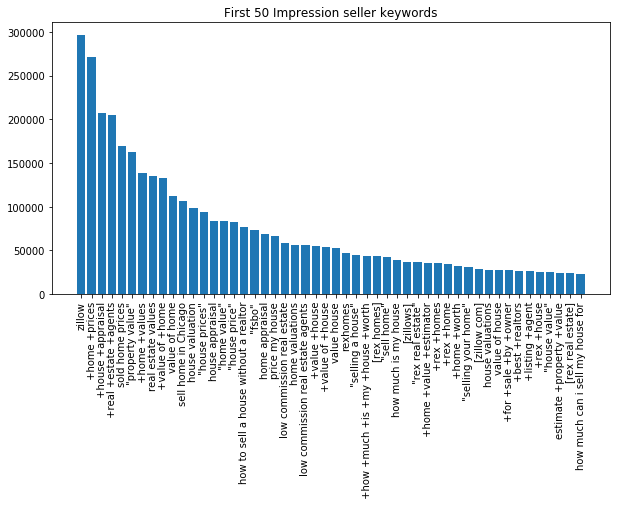

In [16]:
plt.figure(figsize=(10, 5))
num = 50
plt.bar(height =seller_word_sorted.iloc[:num].values, x= seller_word_sorted.iloc[:num].index)
plt.xticks(rotation=90)
plt.title('First {} Impression seller keywords'.format(num))

In [17]:
print(buyer_word_sorted.iloc[:20].index)
print(seller_word_sorted.iloc[:50].index)

Index(['"properties for sale"', '"homes for sales"', '"homes for sale"',
       '"for sale by owner"', '"Homes in"', '"townhomes for sale"',
       '"homes for sale in"', '[Condos In Tampa Fl for sale]',
       '"townhouse for sale"', '"condominium for sale near me"',
       '"townhouses for sale"', '"zillow homes for sale"', '"for sale homes"',
       '"NY Home For Sale"', '"Homes near me"', ' +buy +Houses +In +Texas',
       '"NJ Home For Sale"', '"townhouses in"', '"for sale home"',
       '[Homes In Corona Ca for sale]'],
      dtype='object', name='Keyword')
Index(['zillow', ' +home +prices', ' +house +appraisal',
       ' +real +estate +agents', 'sold home prices', '"property value"',
       ' +home +values', 'real estate values', ' +value of +home',
       'value of home', 'sell home in Chicago', 'house valuation',
       '"house prices"', 'house appraisal', '"home value"', '"house price"',
       'how to sell a house without a realtor', '"fsbo"', 'home appraisal',
       'price

In [18]:
# clean the keywords and delete duplicates
clean_keywords = lambda s: s.strip('""').strip('[]').strip(' ').replace('+','')
buyer_keywords = [clean_keywords(x) for x in buyer_word_sorted.iloc[:20].index]
seller_keywords = [clean_keywords(x) for x in seller_word_sorted.iloc[:50].index]
print(set(buyer_keywords))
print()
print(set(seller_keywords))

{'Homes in', 'townhomes for sale', 'for sale homes', 'buy Houses In Texas', 'townhouse for sale', 'townhouses for sale', 'Condos In Tampa Fl for sale', 'condominium for sale near me', 'Homes near me', 'homes for sale in', 'NY Home For Sale', 'Homes In Corona Ca for sale', 'for sale home', 'zillow homes for sale', 'properties for sale', 'townhouses in', 'for sale by owner', 'homes for sales', 'NJ Home For Sale', 'homes for sale'}

{'fsbo', 'how much can i sell my house for', 'value house', 'sell home in Chicago', 'home value', 'selling your home', 'home values', 'estimate property value', 'low commission real estate agents', 'price my house', 'rex homes', 'zillow', 'house valuation', 'value of home', 'how much is my house', 'rex house', 'real estate values', 'low commission real estate', 'how to sell a house without a realtor', 'house valuations', 'home prices', 'how much is my house worth', 'real estate agents', 'zillow com', 'sold home prices', 'rex real estate', 'selling a house', 'r

In [19]:
#exclude those with obvious locations not in Denver, delete phrases with same words(because word sequence does not impact the google trends)
buyer_keywords = ['homes for sale', 'homes for sale in', 'properties for sale','for sale home','homes for sales', #home for sale
                  'townhomes for sale','townhouses for sale','townhouse for sale', #townhome for sale
                  'Homes in', 
                  'townhouses in',  
                  'Homes near me', 
                  'condominium for sale near me', 
                  'for sale by owner',
                  'zillow homes for sale']

seller_keywords = ['selling a house','sell home', 'selling your home',
                 
                 'house appraisal', 'home values', 'home value estimator', 'home valuations','house value', 'house valuation', 'real estate values', 
                 'value of house','how much is my house','property value','house valuations', 'home worth', 
                 'how much can i sell my house for', 'estimate property value','value of home','home value', 'home prices', 
                 'low commission real estate', 'home appraisal', 'price my house','how much is my house worth', 
                 'sold home prices', 'house prices','house price', 
                 
                 'rexhomes', 'rex real estate', 'rex home', 'zillow', 'zillow com','zillows','real estate agents', 'rex homes'
                 'listing agent', 'best realtors','low commission real estate agents', 'rex house', 
                 'how to sell a house without a realtor',
                 
                 'for sale by owner', 'fsbo', 
                  
                 ]

In [74]:
%time buyer_keyword_to_time_series = get_keyword_to_time_series(buyer_keywords,geo='US-CO')

homes for sale
homes for sale in
properties for sale
for sale home
homes for sales
townhomes for sale
townhouses for sale
townhouse for sale
Homes in
townhouses in
Homes near me
condominium for sale near me
for sale by owner
zillow homes for sale
CPU times: user 2.26 s, sys: 52.4 ms, total: 2.31 s
Wall time: 20.7 s


In [79]:
%time seller_keyword_to_time_series = get_keyword_to_time_series(seller_keywords,geo='US-CO')

selling a house
sell home
selling your home
house appraisal
home values
home value estimator
home valuations
house value
house valuation
real estate values
value of house
how much is my house
property value
house valuations
home worth
how much can i sell my house for
estimate property value
value of home
home value
home prices
low commission real estate
home appraisal
price my house
how much is my house worth
sold home prices
house prices
house price
rexhomes
rex real estate
rex home
zillow
zillow com
zillows
real estate agents
rex homeslisting agent
best realtors
low commission real estate agents
rex house
how to sell a house without a realtor
for sale by owner
fsbo
CPU times: user 4.89 s, sys: 137 ms, total: 5.02 s
Wall time: 55.6 s


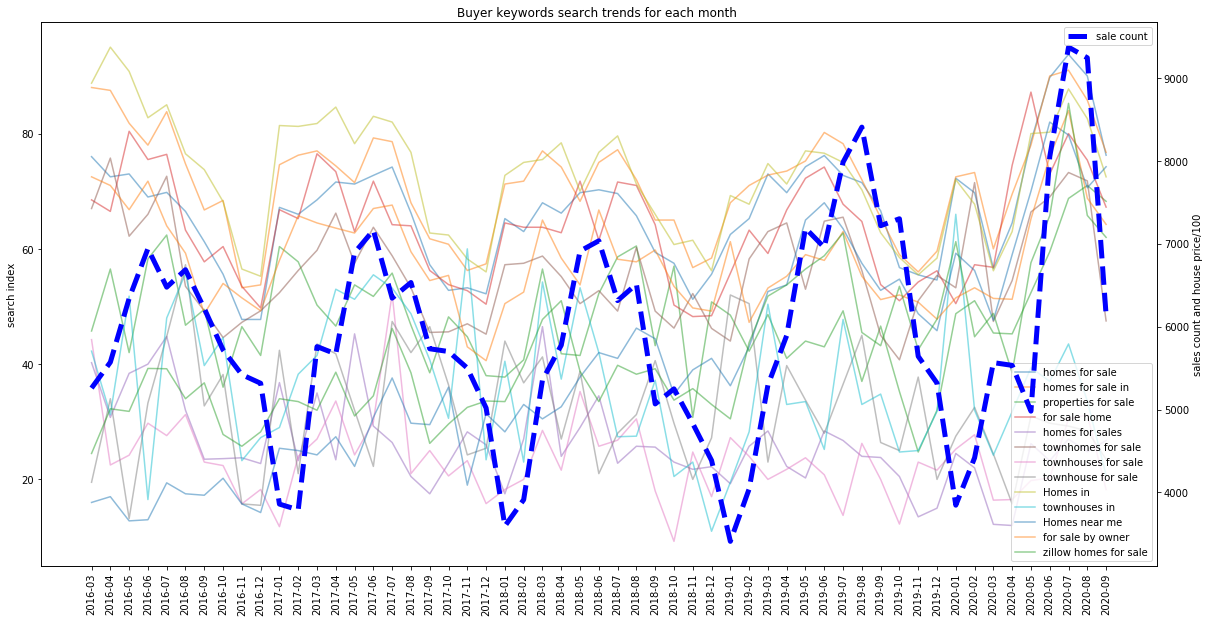

In [80]:
fig, ax1 = plt.subplots(figsize=(20,10))
for keyword, time_series in buyer_keyword_to_time_series.items():
    time_series = pd.Series(time_series, index=monthData.month.values)
    ax1.plot(time_series, label=keyword,alpha=0.5)
ax2 = ax1.twinx()
#ax2.plot(monthData['month'],monthData['mean_price']/100,label='house price', color='black', linewidth=5)
ax2.plot(monthData['month'],monthData['count_sale'],'--',label='sale count',color='blue', linewidth=5)
ax2.set_ylabel('sales count and house price/100')
ax1.set_ylabel('search index')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

ax2.legend()
ax1.legend()
plt.title('Buyer keywords search trends for each month ')
plt.show()

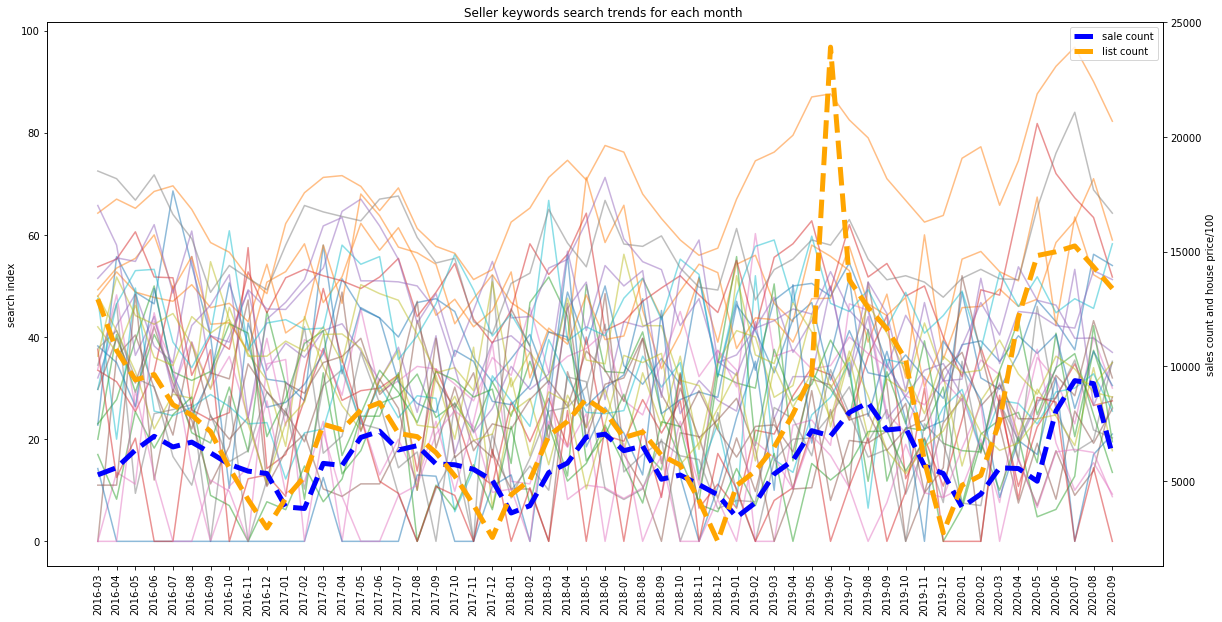

In [81]:
fig, ax1 = plt.subplots(figsize=(20,10))
for keyword, time_series in seller_keyword_to_time_series.items():
    time_series = pd.Series(time_series, index=monthData.month.values)
    ax1.plot(time_series, label=keyword,alpha=0.5)
ax2 = ax1.twinx()
#ax2.plot(monthData['month'],monthData['mean_price']/100,label='house price', color='black', linewidth=5)
ax2.plot(monthData['month'],monthData['count_sale'],'--',label='sale count',color='blue', linewidth=5)
ax2.plot(monthData['month'],monthData['count_list'],'--',label='list count',color='orange', linewidth=5)
ax2.set_ylabel('sales count and house price/100')
ax1.set_ylabel('search index')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

ax2.legend()
plt.title('Seller keywords search trends for each month ')
plt.show()

From the two trend plots, there's obvious evidence that the google trends move ahead of the sales count, and seller's google trends weakly move ahead of the listing count. The plots align with what we discussed intuitively.

In [82]:
#save the google trends data
buyer_trend = pd.DataFrame(buyer_keyword_to_time_series, index=monthData.month.values).reset_index()
buyer_trend.to_csv('buyer_search_trend.csv')
seller_trend = pd.DataFrame(seller_keyword_to_time_series, index=monthData.month.values).reset_index()
seller_trend.to_csv('seller_search_trend.csv')

In [85]:
buyer_trend.head()

,index,homes for sale,homes for sale in,properties for sale,for sale home,homes for sales,townhomes for sale,townhouses for sale,townhouse for sale,Homes in,townhouses in,Homes near me,for sale by owner,zillow homes for sale
0,2016-03,76.0,88.0,45.75,68.5,40.25,67.00,44.25,19.50,88.75,42.25,16.0,72.50,24.50
1,2016-04,72.5,87.5,56.50,66.5,30.75,75.75,22.50,34.00,95.00,31.25,17.0,71.00,32.25
2,2016-05,73.0,81.8,42.00,80.4,38.40,62.20,24.20,13.20,90.80,51.80,12.8,66.80,31.80
3,2016-06,69.0,78.0,58.25,75.5,40.00,66.00,29.75,33.25,82.75,16.50,13.0,71.75,39.25
4,2016-07,69.8,83.8,62.40,76.4,44.80,72.60,27.60,44.80,85.00,48.00,19.4,64.00,39.20


Text(0.5, 1, 'correlation heatmap for buyer terms')

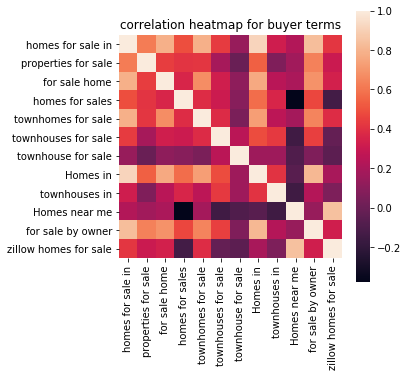

In [86]:
plt.figure(figsize=(5,5))
sns.heatmap(buyer_trend.iloc[:,2:].corr(),square=True)
plt.title('correlation heatmap for buyer terms')

Text(0.5, 1, 'correlation heatmap for seller terms')

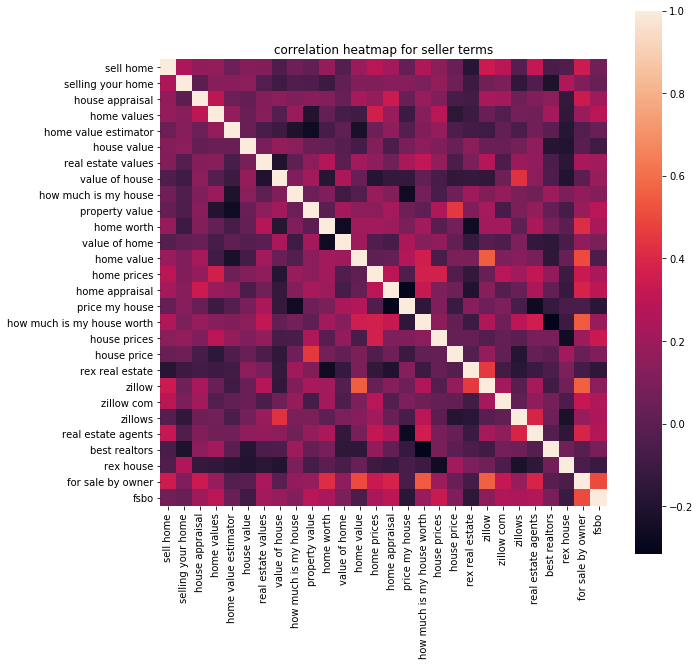

In [87]:
plt.figure(figsize=(10,10))
sns.heatmap(seller_trend.iloc[:,2:].corr(),square=True)
plt.title('correlation heatmap for seller terms')

From the correlation heatmap, it is worthwhile to notice that some keywords are very close to each other, like 'home for sale' and 'for sale home'. We could do some preprocessing before we build models.

### 2.2 particular search terms about buy/sell houses in a certain area

Ispired from the general used search terms, it is also promising to study some terms related to a particular area, such as "sell house in Denver". We then generate a list of keywords with the particular area.

In [88]:
denver_keywords= ['homes for sale in Denver',  'Homes in Denver', 'townhouses in Denver',
                'selling a house in Denver','sell home in Denver', 'selling your home in Denver',                 
                'house appraisal in Denver', 'home values in Denver', 'house price in Denver'                 
                 'for sale by owner in Denver','houses in Denver'                 
                 ]

In [89]:
denver_keyword_to_time_series = get_keyword_to_time_series(denver_keywords,geo='US')

homes for sale in Denver
Homes in Denver
townhouses in Denver
selling a house in Denver
sell home in Denver
selling your home in Denver
house appraisal in Denver
home values in Denver
house price in Denverfor sale by owner in Denver
houses in Denver


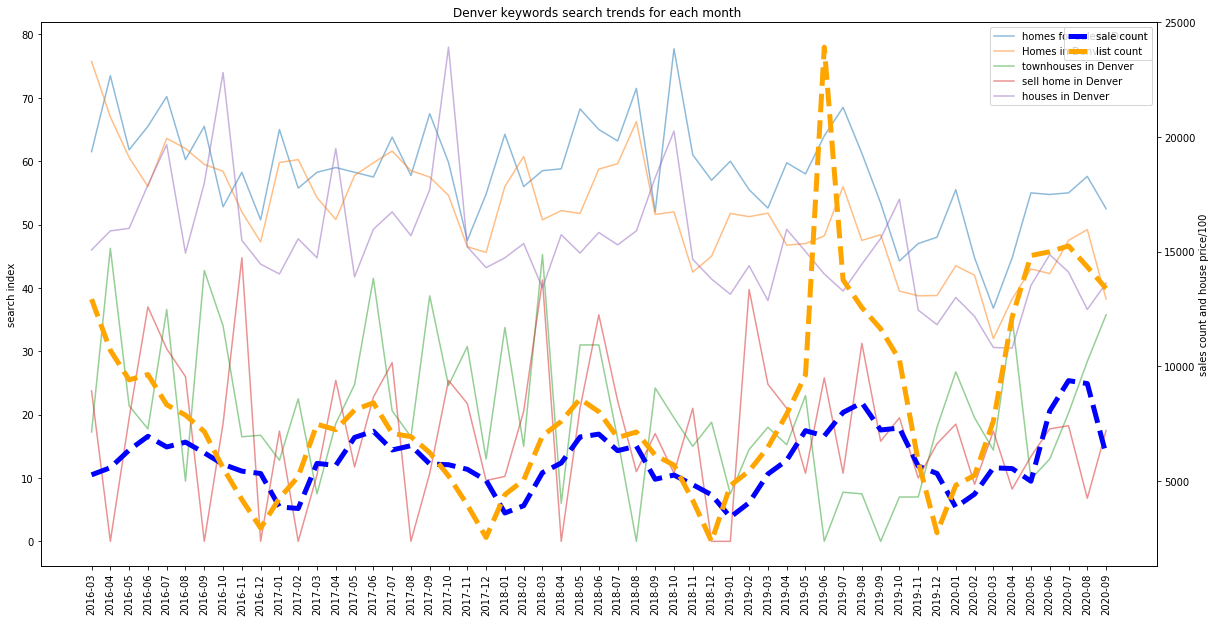

In [90]:
fig, ax1 = plt.subplots(figsize=(20,10))
for keyword, time_series in denver_keyword_to_time_series.items():
    time_series = pd.Series(time_series, index=monthData.month.values)
    ax1.plot(time_series, label=keyword,alpha=0.5)
ax2 = ax1.twinx()
#ax2.plot(monthData['month'],monthData['mean_price']/100,label='house price', color='black', linewidth=5)
ax2.plot(monthData['month'],monthData['count_sale'],'--',label='sale count',color='blue', linewidth=5)
ax2.plot(monthData['month'],monthData['count_list'],'--',label='list count',color='orange', linewidth=5)
ax2.set_ylabel('sales count and house price/100')
ax1.set_ylabel('search index')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.legend()
plt.title('Denver keywords search trends for each month ')
ax2.legend()
plt.show()


In [91]:
denver_trend = pd.DataFrame(denver_keyword_to_time_series, index=monthData.month.values).reset_index()
denver_trend.to_csv('denver_search_trend.csv')

Text(0.5, 1, 'correlation heatmap for denver terms')

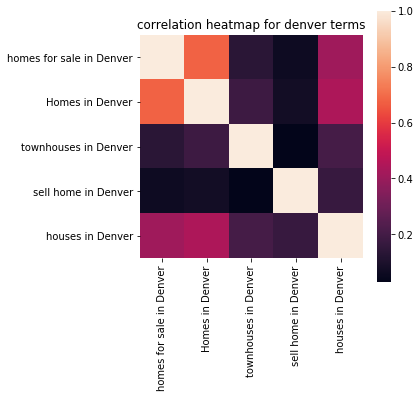

In [92]:
plt.figure(figsize=(5,5))
sns.heatmap(denver_trend.corr(),square=True)
plt.title('correlation heatmap for denver terms')

Terms related Denver is a relatively unpopular search, thus only a few keywords have records in google trends.

##  3. Merge google trends with monthly sells and price

In [2]:
#read google trends data
buyer_trend = pd.read_csv('buyer_search_trend.csv')
seller_trend = pd.read_csv('seller_search_trend.csv')
denver_trend = pd.read_csv('denver_search_trend.csv')

In [32]:
merged = pd.merge(pd.merge(monthData, seller_trend, left_on ='month', right_on='index').drop(['Unnamed: 0','index'],axis=1),buyer_trend,
         left_on='month',right_on='index')
merged = merged.drop(['index','Unnamed: 0', 'for sale by owner_y'], axis=1)
merged = pd.merge(merged, denver_trend, left_on ='month', right_on='index').drop(['Unnamed: 0','index'],axis=1)

In [33]:
merged.head()

,month,count_sale,mean_price,count_list,selling a house,sell home,selling your home,house appraisal,home values,home value estimator,...,townhouse for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,homes for sale in Denver,Homes in Denver,townhouses in Denver,sell home in Denver,houses in Denver
0,2016-03,5259,392825.600494,12926,22.75,48.00,23.00,33.50,32.00,0.00,...,19.50,88.75,42.25,16.0,24.50,61.5,75.75,17.25,23.75,46.00
1,2016-04,5571,403625.623586,10692,55.75,52.75,27.75,31.25,42.25,36.25,...,34.00,95.00,31.25,17.0,32.25,73.5,67.00,46.25,0.00,49.00
2,2016-05,6340,415779.824132,9405,48.80,48.80,39.40,25.40,48.40,40.40,...,13.20,90.80,51.80,12.8,31.80,61.8,60.60,21.40,19.40,49.40
3,2016-06,6941,427446.501945,9635,46.50,47.75,50.00,33.25,38.25,30.00,...,33.25,82.75,16.50,13.0,39.25,65.5,56.00,17.75,37.00,56.25
4,2016-07,6476,418647.276714,8318,68.60,47.00,32.20,50.00,35.00,20.80,...,44.80,85.00,48.00,19.4,39.20,70.2,63.60,36.60,30.40,62.60


In [7]:
merged['count_sale_lead1'] = merged['count_sale'].shift(-3)
merged['mean_price_lead1'] = merged['mean_price'].shift(-3)
merged['count_list_lead1'] = merged['count_list'].shift(-3)


In [8]:
merged.tail()

,month,count_sale,mean_price,count_list,selling a house,sell home,selling your home,house appraisal,home values,home value estimator,...,Homes near me,zillow homes for sale,homes for sale in Denver,Homes in Denver,townhouses in Denver,sell home in Denver,houses in Denver,count_sale_lead1,mean_price_lead1,count_list_lead1
50,2020-05,4981,496792.988540,14829,47.2,47.40,15.40,22.40,26.80,7.00,...,70.00,57.60,55.00,43.00,9.80,13.40,40.40,9242.0,534460.182143,14335.0
51,2020-06,8048,504526.000870,14994,43.0,58.50,40.75,28.25,33.75,17.75,...,82.00,65.75,54.75,42.25,13.00,17.75,45.25,6141.0,539379.842157,13389.0
52,2020-07,9370,537337.274979,15248,37.5,62.75,20.50,34.75,53.25,9.00,...,79.75,85.25,55.00,47.50,20.25,18.25,42.50,NaN,NaN,NaN
53,2020-08,9242,534460.182143,14335,56.2,71.00,37.40,26.60,26.60,13.80,...,70.60,65.80,57.60,49.20,28.40,6.80,36.60,NaN,NaN,NaN
54,2020-09,6141,539379.842157,13389,54.0,59.00,26.25,27.50,35.00,28.25,...,74.25,62.00,52.50,38.25,35.75,17.50,40.75,NaN,NaN,NaN


### 3.1 lead count_sale, mean_price, count_list's correlation with features

In [9]:
target_column_names = ['count_sale_lead1', 'mean_price_lead1','count_list_lead1']
feature_column_names = merged.columns[1:-3]
corr = []
for j in target_column_names:
    corr_1 = []
    for i in feature_column_names:
        corr_1.append(np.corrcoef(merged[j][:-3], merged[i][:-3])[0][1])
    corr.append(corr_1)
corr = np.array(corr)

Text(0.5, 1.0, 'correlation between count_sale_lead1 and features')

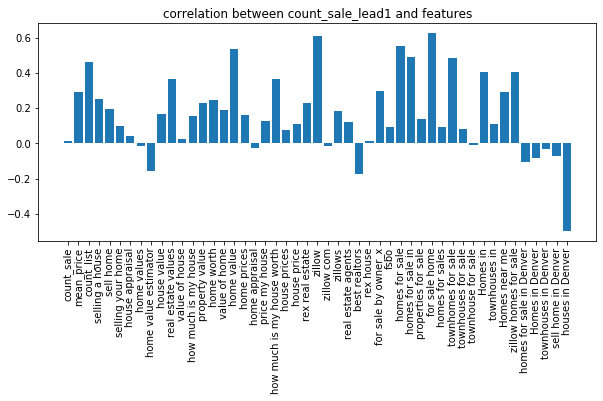

In [10]:
plt.figure(figsize=(10, 4))
plt.bar(height=corr[0],x=feature_column_names)
plt.xticks(rotation=90)
plt.title('correlation between count_sale_lead1 and features')

From the correlation, we can see that many terms have a strong correlation with the sales number three months later. Thus, we expect that google trends can predict the monthly sale house number quite well. 

Text(0.5, 1.0, 'correlation between mean_price_lead1 and features')

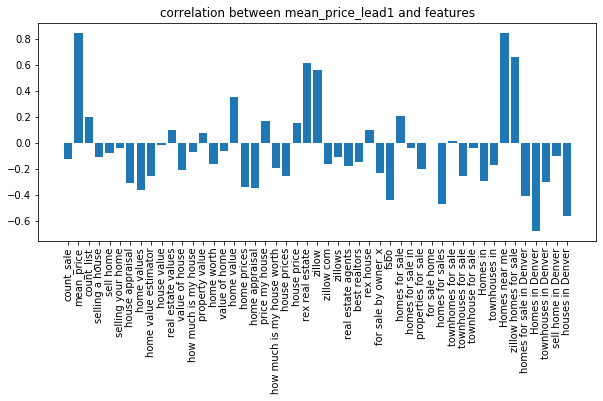

In [11]:
plt.figure(figsize=(10, 4))
plt.bar(height=corr[1],x=feature_column_names)
plt.xticks(rotation=90)
plt.title('correlation between mean_price_lead1 and features')

From the correlation plot, we can see that 'mean_price' has the mose positive correlation with mean price lead1, which means that the price data is autocorrelated. 'homes near me' and 'zillow homes for sale' also have strong correlations with the mean price. 

Text(0.5, 1.0, 'correlation between count_list_lead1 and features')

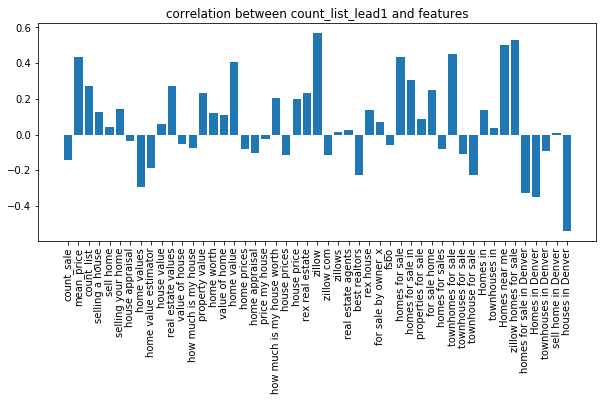

In [12]:
plt.figure(figsize=(10, 4))
plt.bar(height=corr[2],x=feature_column_names)
plt.xticks(rotation=90)
plt.title('correlation between count_list_lead1 and features')

Apart from the autocorrelated term, 'zillow' is a term that have strong correlation with listing data. This is a seller term that has the largest ads impression from our data set.

### 3.2 Baseline model with google trends: linear regression (Lasso)

In [42]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [14]:
#Since some features are strongly correlated, use Lasso regression to select features

#split the data first
merged = merged.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(merged[feature_column_names],merged[target_column_names], test_size = 0.2, shuffle=False)
#standardize the features
std = StandardScaler()
std.fit(train_X)
train_X_std =std.transform(train_X)
test_X_std = std.transform(test_X)


### 3.2.1 predict the sales number

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11748.246239823886, tolerance: 4823.64992
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10776.572982231979, tolerance: 4622.507387096774
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14558.216246767684, tolerance: 5191.9672
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number 

Text(0, 0.5, 'score')

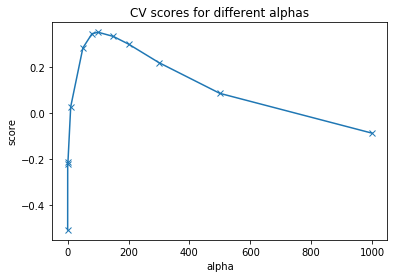

In [15]:
#linear regression(lasso)
#using cross validation to choose alpha in Lasso
alphas = [1e-2, 1e-1, 1., 10,50, 80, 100, 150, 200,300,500,1e3]
scores_cv = []
for a in alphas:
    lr = Lasso(alpha=a)
    scores_cv.append(cross_val_score(lr, train_X_std, train_y['count_sale_lead1'], cv=4).mean())
plt.plot(alphas,scores_cv,'x-')
plt.title('CV scores for different alphas')
plt.xlabel('alpha')
plt.ylabel('score')

In [16]:
#alpha =200
lr = Lasso(alpha=150)
lr.fit(train_X_std, train_y['count_sale_lead1'])
train_y_pred = lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting sales count lead 1: ', lr.score(train_X_std, train_y['count_sale_lead1']))
print('test score for predicting sales count lead 1: ', lr.score(test_X_std, test_y['count_sale_lead1']))
print('training MSE for predicting sales count lead 1: ', mean_squared_error(train_y['count_sale_lead1'], train_y_pred))
print('test MSE for predicting sales count lead 1: ', mean_squared_error(test_y['count_sale_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
selected_features = feature_column_names[lr.coef_!=0]

print(feature_column_names[lr.coef_!=0])

training score for predicting sales count lead 1:  0.750366380666055
test score for predicting sales count lead 1:  0.29316291150953944
training MSE for predicting sales count lead 1:  362328.5132940665
test MSE for predicting sales count lead 1:  2239576.477570619
[ -43.20908957  103.33882544    8.88006964  132.06858527  313.13880871
   14.02629272  193.69779288   65.43602487  129.41753055  -57.22342142
 -279.60683555]
Index(['home value estimator', 'house value', 'real estate values',
       'home value', 'zillow', 'rex house', 'homes for sale', 'for sale home',
       'townhomes for sale', 'homes for sale in Denver', 'houses in Denver'],
      dtype='object')


In [17]:
lr = LassoCV(cv=4)
lr.fit(train_X_std, train_y['count_sale_lead1'])
train_y_pred = lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting sales count lead 1: ', lr.score(train_X_std, train_y['count_sale_lead1']))
print('test score for predicting sales count lead 1: ', lr.score(test_X_std, test_y['count_sale_lead1']))
print('training MSE for predicting sales count lead 1: ', mean_squared_error(train_y['count_sale_lead1'], train_y_pred))
print('test MSE for predicting sales count lead 1: ', mean_squared_error(test_y['count_sale_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
selected_features = feature_column_names[lr.coef_!=0]

print(feature_column_names[lr.coef_!=0])

training score for predicting sales count lead 1:  0.8399308121033848
test score for predicting sales count lead 1:  0.2747815002985189
training MSE for predicting sales count lead 1:  232331.0098596272
test MSE for predicting sales count lead 1:  2297817.0210325797
[ -77.95428442  166.98577407   10.43221977   33.82623094  153.76968817
   -4.10551269  270.89715839  -45.55982685   38.76206269   76.98876204
  266.96612454  -44.78477627  112.37451316  151.62520684 -101.83734101
  -33.90750398 -297.49573792]
Index(['home value estimator', 'house value', 'real estate values',
       'value of home', 'home value', 'home appraisal', 'zillow', 'zillow com',
       'zillows', 'rex house', 'homes for sale', 'properties for sale',
       'for sale home', 'townhomes for sale', 'homes for sale in Denver',
       'sell home in Denver', 'houses in Denver'],
      dtype='object')


In [ ]:
#train_X_std_con = sm.add_constant(train_X_std[:,lr.coef_!=0])
#test_X_std_con = sm.add_constant(test_X_std[:,lr.coef_!=0])
#results = sm.OLS(train_y['count_sale_lead1'], train_X_std_con).fit()
#print(results.summary())

Text(0.5, 1.0, 'model prediction for house sales number 3 month ahead')

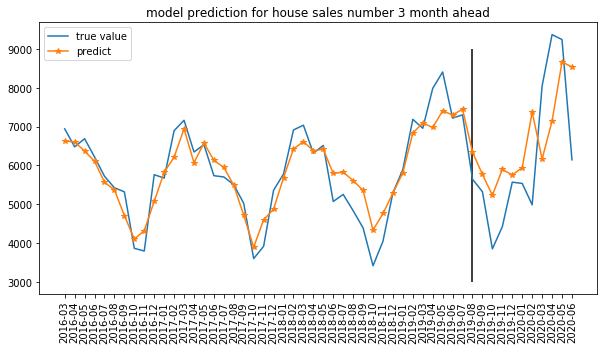

In [18]:
plt.figure(figsize=(10,5))
plt.plot(merged.month, merged['count_sale_lead1'],label='true value')
plt.plot(np.append(train_y_pred,test_y_pred),'-*',label='predict')
plt.legend()
plt.xticks(rotation=90)
plt.vlines(x=merged.month[len(train_y_pred)],ymin=3000,ymax=9000)
plt.title('model prediction for house sales number 3 month ahead')

### 3.2.2 predict the mean price

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1877491.4720005672, tolerance: 1413464.6293541486
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4437041.51265179, tolerance: 3706937.815196213
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4056686.436517317, tolerance: 3278402.4442583467
  positive)


Text(0, 0.5, 'score')

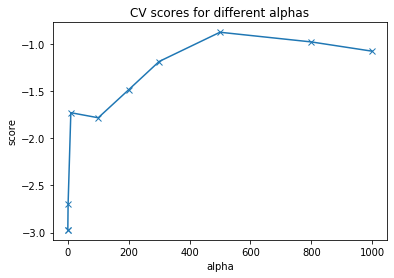

In [112]:
alphas = [1e-2, 1e-1, 1., 10,100,200,300,500, 800,1e3]
scores_cv = []
for a in alphas:
    lr = Lasso(alpha=a)
    scores_cv.append(cross_val_score(lr, train_X_std, train_y['mean_price_lead1'], cv=4).mean())

plt.plot(alphas,scores_cv,'x-')
plt.title('CV scores for different alphas')
plt.xlabel('alpha')
plt.ylabel('score')

In [113]:

lr = Lasso(alpha=600)
lr.fit(train_X_std, train_y['mean_price_lead1'])
train_y_pred = lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting mean_price_lead1: ', lr.score(train_X_std, train_y['mean_price_lead1']))
print('test score for predicting mean_price_lead1: ', lr.score(test_X_std, test_y['mean_price_lead1']))
print('training MSE for predicting mean_price_lead1: ', mean_squared_error(train_y['mean_price_lead1'], train_y_pred))
print('test MSE for predicting mean_price_lead1: ', mean_squared_error(test_y['mean_price_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
print(feature_column_names[lr.coef_!=0])

training score for predicting mean_price_lead1:  0.9713758417510303
test score for predicting mean_price_lead1:  -0.4650053246645749
training MSE for predicting mean_price_lead1:  27397370.161368724
test MSE for predicting mean_price_lead1:  676811116.608919
[-13438.31969639  19257.84790743   -143.81532278   1252.01550237
  -1299.29727438  -1295.40742796   1868.83222804   1301.36837129
    337.44897561   -572.18163193    376.61528557   -555.63479896
  -1260.30921027   -299.73327598   1108.83850167   1543.86586855
  -1116.58833385   -713.88406946    250.41783658    417.5962252
   3461.12161008   6327.48342212   -319.23055477   -305.47264325
  -3477.8942101 ]
Index(['count_sale', 'mean_price', 'selling a house', 'sell home',
       'home values', 'home value estimator', 'house value',
       'real estate values', 'property value', 'home worth', 'home value',
       'home prices', 'home appraisal', 'how much is my house worth',
       'rex real estate', 'rex house', 'for sale by owner_x',

In [ ]:
lr = LassoCV(cv=4)
lr.fit(train_X_std, train_y['mean_price_lead1'])
train_y_pred = lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting mean_price_lead1: ', lr.score(train_X_std, train_y['mean_price_lead1']))
print('test score for predicting mean_price_lead1: ', lr.score(test_X_std, test_y['mean_price_lead1']))
print('training MSE for predicting mean_price_lead1: ', mean_squared_error(train_y['mean_price_lead1'], train_y_pred))
print('test MSE for predicting mean_price_lead1: ', mean_squared_error(test_y['mean_price_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
print(feature_column_names[lr.coef_!=0])

Text(0.5, 1.0, 'model prediction for mean trade price 3 month later')

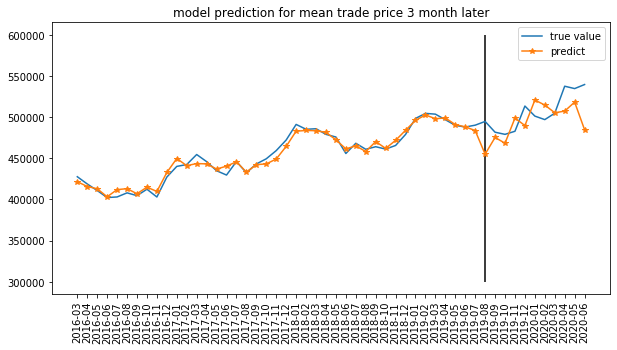

In [114]:
plt.figure(figsize=(10,5))
plt.plot(merged.month, merged['mean_price_lead1'],label='true value')
plt.plot(np.append(train_y_pred,test_y_pred),'-*',label='predict')
plt.legend()
plt.xticks(rotation=90)
plt.vlines(x=merged.month[len(train_y_pred)],ymin=300000,ymax=600000)
plt.title('model prediction for mean trade price 3 month later')

### 3.2.3 predict the newly listed house number

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54793.22161820909, tolerance: 48326.37972
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30509.459457563906, tolerance: 10850.407709677418
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 174653.08234089412, tolerance: 48326.37972
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numb

Text(0, 0.5, 'score')

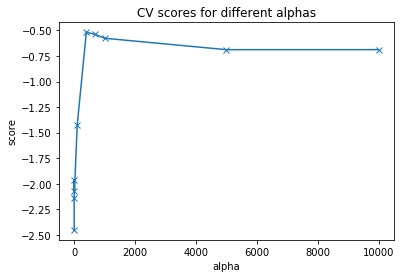

In [19]:
alphas = [1e-2, 1e-1, 1.,10,100,400,700,1e3,5e3, 1e4]
scores_cv = []
for a in alphas:
    lr = Lasso(alpha=a)
    scores_cv.append(cross_val_score(lr, train_X_std, train_y['count_list_lead1'], cv=4).mean())
plt.plot(alphas,scores_cv,'x-')
plt.title('CV scores for different alphas')
plt.xlabel('alpha')
plt.ylabel('score')

In [20]:

lr = Lasso(alpha=400)
lr.fit(train_X_std, train_y['count_list_lead1'])
train_y_pred= lr.predict(train_X_std)
test_y_pred = lr.predict(test_X_std)
print('training score for predicting count_list_lead1: ', lr.score(train_X_std, train_y['count_list_lead1']))
print('test score for predicting count_list_lead1: ', lr.score(test_X_std, test_y['count_list_lead1']))
print('training MSE for predicting count_list_lead1: ', mean_squared_error(train_y['count_list_lead1'], train_y_pred))
print('test MSE for predicting count_list_lead1: ', mean_squared_error(test_y['count_list_lead1'], test_y_pred))
print(lr.coef_[lr.coef_!=0])
print(feature_column_names[lr.coef_!=0])

training score for predicting count_list_lead1:  0.6787091123268962
test score for predicting count_list_lead1:  0.34254380070376034
training MSE for predicting count_list_lead1:  4217488.906381293
test MSE for predicting count_list_lead1:  14108188.368786806
[-104.25710041  298.51263923  526.15385641 -220.64190286 -397.77147068
  254.79011232 1047.9421216  -547.70188763  535.85076603 -274.23809982
   34.51154791 -346.19482066 -652.73089666]
Index(['count_sale', 'selling your home', 'home value', 'home prices',
       'home appraisal', 'house price', 'zillow', 'best realtors',
       'townhomes for sale', 'townhouse for sale', 'zillow homes for sale',
       'homes for sale in Denver', 'houses in Denver'],
      dtype='object')


Text(0.5, 1.0, 'model prediction for listing number 3 month later')

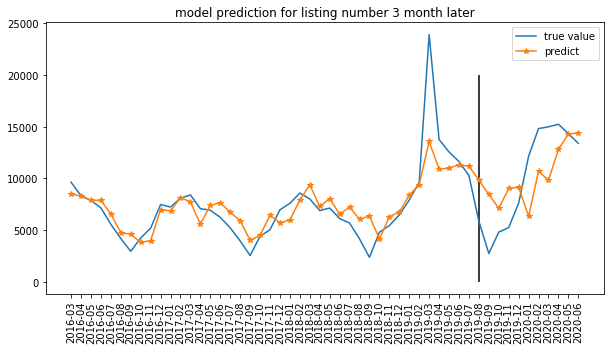

In [21]:
plt.figure(figsize=(10,5))
plt.plot(merged.month, merged['count_list_lead1'],label='true value')
plt.plot(np.append(train_y_pred,test_y_pred),'-*',label='predict')
plt.legend()
plt.xticks(rotation=90)
plt.vlines(x=merged.month[len(train_y_pred)],ymin=0,ymax=20000)
plt.title('model prediction for listing number 3 month later')

## 4. Future works

We can find that using google trends to predict house sales, price, and listing data is very promising from EDA and Lasso regression baseline model. The results lead to many possible discussions in the future.
1. Time series: Google trend is one kind of time series data, but time series property has not been used here.
2. Model improvement: More feature engineering, dimension reduction, and build more models(both linear and nonlinear).
3. Other features: Include other predictive features except for google trends, such as real-time bidding data, census data, etc.
4. Time intervals: From monthly data to weekly or even daily data, or change the prediction horizon.
5. Space: Narrow down the Denver area to a specific zipcode in Denver(maybe hard by google trends API restriction), or try models in other cities.
 


## 5. Milestone 2 - Further prediction models with Google trends

In [200]:
merged = pd.merge(pd.merge(monthData, seller_trend, left_on ='month', right_on='index').drop(['Unnamed: 0','index'],axis=1),buyer_trend,
         left_on='month',right_on='index')
merged = merged.drop(['index','Unnamed: 0', 'for sale by owner_y'], axis=1)
merged = pd.merge(merged, denver_trend, left_on ='month', right_on='index').drop(['Unnamed: 0','index'],axis=1)
merged['count_sale_future'] = -merged['count_sale'].diff(-3)
merged['count_list_future'] = -merged['count_list'].diff(-3)
merged.head()


,month,count_sale,mean_price,count_list,selling a house,sell home,selling your home,house appraisal,home values,home value estimator,...,townhouses in,Homes near me,zillow homes for sale,homes for sale in Denver,Homes in Denver,townhouses in Denver,sell home in Denver,houses in Denver,count_sale_future,count_list_future
0,2016-03,5259,392825.600494,12926,22.75,48.00,23.00,33.50,32.00,0.00,...,42.25,16.0,24.50,61.5,75.75,17.25,23.75,46.00,1682.0,-3291.0
1,2016-04,5571,403625.623586,10692,55.75,52.75,27.75,31.25,42.25,36.25,...,31.25,17.0,32.25,73.5,67.00,46.25,0.00,49.00,905.0,-2374.0
2,2016-05,6340,415779.824132,9405,48.80,48.80,39.40,25.40,48.40,40.40,...,51.80,12.8,31.80,61.8,60.60,21.40,19.40,49.40,346.0,-1541.0
3,2016-06,6941,427446.501945,9635,46.50,47.75,50.00,33.25,38.25,30.00,...,16.50,13.0,39.25,65.5,56.00,17.75,37.00,56.25,-723.0,-2487.0
4,2016-07,6476,418647.276714,8318,68.60,47.00,32.20,50.00,35.00,20.80,...,48.00,19.4,39.20,70.2,63.60,36.60,30.40,62.60,-757.0,-2759.0


In [201]:
target_column_names = ['count_sale_future', 'count_list_future']
feature_column_names = merged.columns[1:-2]

In [204]:
feature_column_names

array(['count_sale', 'mean_price', 'count_list', 'selling a house',
       'sell home', 'selling your home', 'house appraisal', 'home values',
       'home value estimator', 'house value', 'real estate values',
       'value of house', 'how much is my house', 'property value',
       'home worth', 'value of home', 'home value', 'home prices',
       'home appraisal', 'price my house', 'how much is my house worth',
       'house prices', 'house price', 'rex real estate', 'zillow',
       'zillow com', 'zillows', 'real estate agents', 'best realtors',
       'rex house', 'for sale by owner_x', 'fsbo', 'homes for sale',
       'homes for sale in', 'properties for sale', 'for sale home',
       'homes for sales', 'townhomes for sale', 'townhouses for sale',
       'townhouse for sale', 'Homes in', 'townhouses in', 'Homes near me',
       'zillow homes for sale', 'homes for sale in Denver',
       'Homes in Denver', 'townhouses in Denver', 'sell home in Denver',
       'houses in Denver', '

In [203]:
f = feature_column_names.copy()
for i, col in enumerate(f):
    merged[str(col)+'_diff'] = merged[col].diff(1)
    #print(i, len(merged.columns))
    merged[str(col)+'_diff3'] = merged[col].diff(3)
    #print(i, len(merged.columns))
    feature_column_names = np.append(feature_column_names,str(col)+'_diff')
    feature_column_names = np.append(feature_column_names,str(col)+'_diff3')

In [837]:
merged['t'] = merged['month'].apply(lambda x: int(x[-2:]))
feature_column_names = np.append(feature_column_names, 't')

In [838]:
merged

,month,count_sale,mean_price,count_list,selling a house,sell home,selling your home,house appraisal,home values,home value estimator,...,homes for sale in Denver_diff3,Homes in Denver_diff,Homes in Denver_diff3,townhouses in Denver_diff,townhouses in Denver_diff3,sell home in Denver_diff,sell home in Denver_diff3,houses in Denver_diff,houses in Denver_diff3,t
3,2016-06,6941,427446.501945,9635,46.50,47.75,50.00,33.25,38.25,30.00,...,4.00,-4.60,-19.75,-3.65,0.50,17.60,13.25,6.85,10.25,6
4,2016-07,6476,418647.276714,8318,68.60,47.00,32.20,50.00,35.00,20.80,...,-3.30,7.60,-3.40,18.85,-9.65,-6.60,30.40,6.35,13.60,7
5,2016-08,6686,410690.159438,7864,54.00,50.25,21.25,25.75,55.75,39.00,...,-1.55,-1.60,1.40,-27.10,-11.90,-4.40,6.60,-17.10,-3.90,8
6,2016-09,6218,402149.781923,7148,40.25,45.75,19.25,23.75,32.75,24.50,...,0.00,-2.50,3.50,33.25,25.00,-26.00,-37.00,11.00,0.25,9
7,2016-10,5719,402886.176779,5559,10.40,46.60,30.20,25.20,40.20,20.00,...,-17.40,-1.10,-5.20,-8.75,-2.60,18.60,-11.80,17.50,11.40,10
8,2016-11,5421,407862.914960,4179,42.75,43.00,17.50,57.50,49.00,24.25,...,-2.00,-6.40,-10.00,-17.50,7.00,26.15,18.75,-26.50,2.00,11
9,2016-12,5317,404484.769607,2939,31.75,54.25,45.00,14.25,33.50,10.75,...,-14.75,-4.75,-12.25,0.25,-26.00,-44.75,0.00,-3.75,-12.75,12
10,2017-01,3860,412263.404404,4236,31.20,40.80,30.60,17.00,38.80,17.60,...,12.20,12.55,1.40,-3.95,-21.20,17.40,-1.20,-1.55,-31.80,1
11,2017-02,3791,402837.726194,5184,27.50,43.50,8.25,27.75,36.00,21.00,...,-2.50,0.45,8.25,9.70,6.00,-17.40,-44.75,5.55,0.25,2
12,2017-03,5759,427031.897725,7468,58.00,58.00,33.00,37.75,41.25,10.25,...,7.50,-6.00,7.00,-15.00,-9.25,10.50,10.50,-3.00,1.00,3


In [839]:
merged = merged.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(merged[feature_column_names],merged[target_column_names], test_size = 0.2, shuffle=False)
#standardize the features
std = StandardScaler()
std.fit(train_X)
train_X_std =std.transform(train_X)
test_X_std = std.transform(test_X)

No handles with labels found to put in legend.


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48],
 <a list of 49 Text xticklabel objects>)

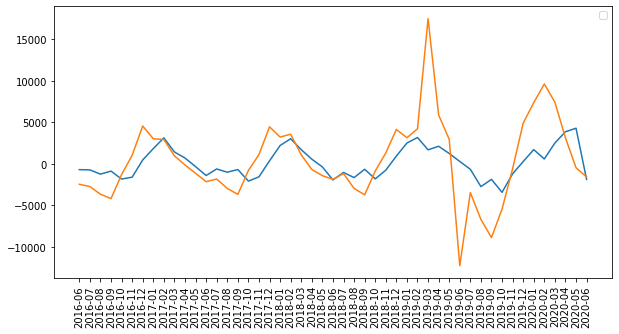

In [840]:
plt.figure(figsize=(10,5))
plt.plot(merged.month, merged[target_column_names])
plt.legend()
plt.xticks(rotation=90)

### 5.1 predict the count of sales in 3 months

### Lasso regression

In [1184]:
#First use lasso to decrease the feature dimension
lr = LassoCV()
lr.fit(train_X_std, train_y['count_sale_future'])
selected_features_sale = feature_column_names[abs(lr.coef_)>0]
selected_features_sale_no = abs(lr.coef_)>0
selected_features_sale

array(['count_sale', 'home value estimator', 'house value', 'home prices',
       'home appraisal', 'zillow com', 'properties for sale',
       'homes for sale in Denver', 'sell home in Denver',
       'houses in Denver', 'house value_diff', 'zillow_diff',
       'zillow_diff3', 'homes for sale_diff3',
       'zillow homes for sale_diff3', 't'], dtype=object)

In [1185]:
from sklearn.metrics import mean_squared_error, r2_score


y_pred_train = lr.predict(train_X_std)
y_pred_test = lr.predict(test_X_std)

lasso_rst = {'r2_train': lr.score(train_X_std, train_y['count_sale_future']),
             'r2_test':lr.score(test_X_std, test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
lasso_rst

{'r2_train': 0.9410124001467024,
 'r2_test': 0.3196856793366558,
 'mse_train': 150209.94723269323,
 'mse_test': 4137492.6463484033}

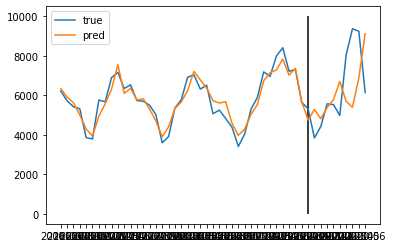

In [1186]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

### Linear model with regularization terms

In [212]:
import sklearn

In [1187]:
#elastic
lr = sklearn.linear_model.ElasticNetCV()
lr.fit(train_X_std, train_y['count_sale_future'])
y_pred_train = lr.predict(train_X_std)
y_pred_test = lr.predict(test_X_std)

elastic_rst = {'r2_train': lr.score(train_X_std, train_y['count_sale_future']),
             'r2_test':lr.score(test_X_std, test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
elastic_rst

{'r2_train': 0.9600850163332821,
 'r2_test': 0.3574379656079465,
 'mse_train': 101642.16895216356,
 'mse_test': 3907893.1772706374}

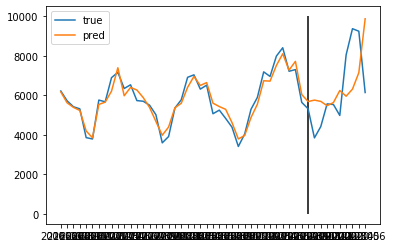

In [1188]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

In [1192]:
#ridge
lr = sklearn.linear_model.RidgeCV()
lr.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_future'])
y_pred_train = lr.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = lr.predict(test_X_std[:,selected_features_sale_no])

ridge_rst = {'r2_train': lr.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_future']),
             'r2_test':lr.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
ridge_rst

{'r2_train': 0.9590886231966864,
 'r2_test': 0.3416441360453528,
 'mse_train': 104179.45070024786,
 'mse_test': 4003947.0918923295}

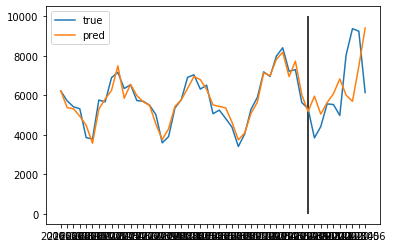

In [1193]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

### PCA

In [1194]:
from sklearn.decomposition import PCA
pca = PCA()
train_X_pca = pca.fit_transform(train_X)


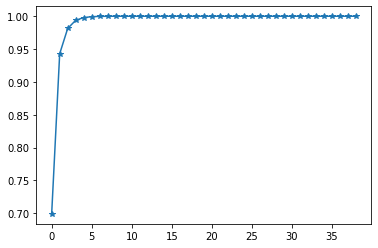

In [851]:
plt.plot(pca.explained_variance_ratio_.cumsum(),'*-')
#from pca, the first 4 components explain over 99% variance

In [1195]:
train_X_pca = pca.transform(train_X)[:,:4]
test_X_pca = pca.transform(test_X)[:,:4]

In [1196]:
lr = LinearRegression()
lr.fit(train_X_pca, train_y['count_sale_future'])
y_pred_train = lr.predict(train_X_pca)
y_pred_test = lr.predict(test_X_pca)

pcalr_rst = {'r2_train': lr.score(train_X_pca, train_y['count_sale_future']),
             'r2_test':lr.score(test_X_pca, test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
pcalr_rst

{'r2_train': 0.1643902644417723,
 'r2_test': 0.04224895070700563,
 'mse_train': 2127852.20279325,
 'mse_test': 5824789.811301327}

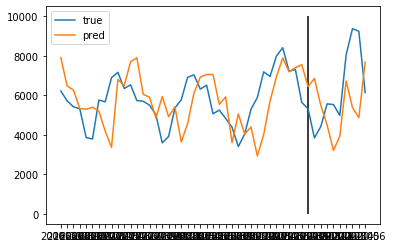

In [1197]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

### K nearest neighbours

In [395]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree


Text(0, 0.5, 'score')

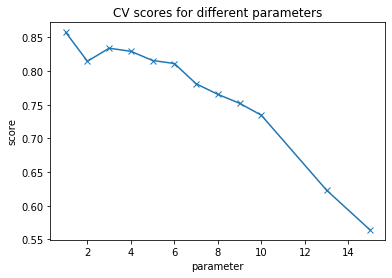

In [1198]:
#using cross validation to find n_neighbors
neighbors = [1,2,3,4,5,6,7,8,9,10,13,15]
scores_cv = []
for n in neighbors:
    knn = KNeighborsRegressor(n_neighbors=n)
    scores_cv.append(cross_val_score(knn, train_X_std[:,selected_features_sale_no], train_y['count_sale_future'], cv=3).mean())

plt.plot(neighbors,scores_cv,'x-')
plt.title('CV scores for different parameters')
plt.xlabel('parameter')
plt.ylabel('score')


In [1199]:
model_knn = KNeighborsRegressor(n_neighbors=3)
model_knn.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_future'])
y_pred_train = model_knn.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model_knn.predict(test_X_std[:,selected_features_sale_no])


knn_rst = {'r2_train': model_knn.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_future']),
             'r2_test':model_knn.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
knn_rst

{'r2_train': 0.9153966338220191,
 'r2_test': 0.24441389228014862,
 'mse_train': 215439.6381766382,
 'mse_test': 4595275.844444444}

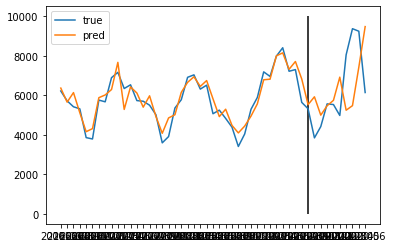

In [1200]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

### Decision Tree

In [1201]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []

model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=3,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_future'])


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                      

In [1202]:
clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [1204]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=6)
model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_future'])

y_pred_train = model.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no])


tree1_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_future']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
tree1_rst

{'r2_train': 0.9405103937356928,
 'r2_test': 0.3961690206715801,
 'mse_train': 151488.28974358973,
 'mse_test': 3672341.0939999996}

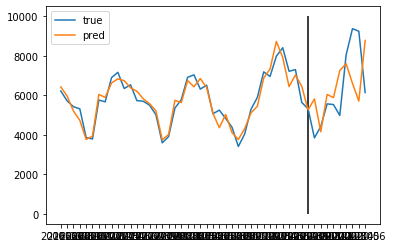

In [1205]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

[Text(348.75, 391.392, 't <= -0.613\nmse = 2546466.505\nsamples = 39\nvalue = 1.462'),
 Text(209.25, 304.416, 'home prices <= 0.19\nmse = 691062.139\nsamples = 12\nvalue = 1979.833'),
 Text(139.5, 217.44, 'house value <= 0.22\nmse = 304689.438\nsamples = 8\nvalue = 2433.25'),
 Text(69.75, 130.464, 'mse = 102979.25\nsamples = 4\nvalue = 2033.5'),
 Text(209.25, 130.464, 'mse = 186799.5\nsamples = 4\nvalue = 2833.0'),
 Text(279.0, 217.44, 'mse = 230287.5\nsamples = 4\nvalue = 1073.0'),
 Text(488.25, 304.416, 'zillow homes for sale_diff3 <= -1.245\nmse = 858428.225\nsamples = 27\nvalue = -877.815'),
 Text(418.5, 217.44, 'mse = 296034.16\nsamples = 5\nvalue = -1951.8'),
 Text(558.0, 217.44, 'zillow_diff <= -0.834\nmse = 664519.926\nsamples = 22\nvalue = -633.727'),
 Text(418.5, 130.464, 'zillow homes for sale_diff3 <= 0.036\nmse = 163429.16\nsamples = 10\nvalue = -1272.8'),
 Text(348.75, 43.488, 'mse = 97500.667\nsamples = 6\nvalue = -1484.0'),
 Text(488.25, 43.488, 'mse = 95051.5\nsamples 

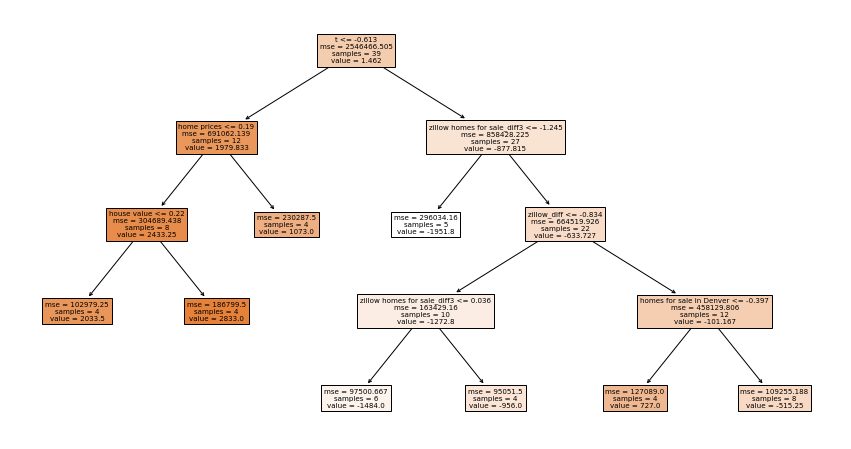

In [882]:
plt.figure(figsize=(15,8))
tree.plot_tree(model, max_depth = 4,filled=True, feature_names=selected_features_sale)

In [883]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []

model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=3,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_future'])

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                      

In [884]:
clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=9, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [1206]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=8)
model.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_future'])

y_pred_train = model.predict(train_X_std[:,selected_features_sale_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no_rf])


tree2_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_future']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no_rf], test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
tree2_rst

{'r2_train': 0.8935716574803105,
 'r2_test': 0.3348465843098527,
 'mse_train': 271016.20940170944,
 'mse_test': 4045288.0125}

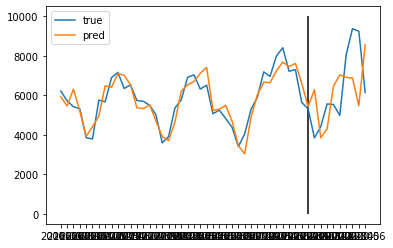

In [1207]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

[Text(418.5, 489.24, 'count_sale <= -0.613\nmse = 2546466.505\nsamples = 39\nvalue = 1.462'),
 Text(209.25, 380.52000000000004, 'count_sale <= -1.214\nmse = 691062.139\nsamples = 12\nvalue = 1979.833'),
 Text(104.625, 271.8, 'mse = 252336.222\nsamples = 6\nvalue = 2619.333'),
 Text(313.875, 271.8, 'mse = 311867.556\nsamples = 6\nvalue = 1340.333'),
 Text(627.75, 380.52000000000004, 'home prices <= 0.316\nmse = 858428.225\nsamples = 27\nvalue = -877.815'),
 Text(523.125, 271.8, 'home appraisal <= 0.538\nmse = 553974.949\nsamples = 23\nvalue = -1117.087'),
 Text(418.5, 163.08000000000004, 'home appraisal <= -0.509\nmse = 354740.249\nsamples = 17\nvalue = -1381.471'),
 Text(313.875, 54.360000000000014, '\n  (...)  \n'),
 Text(523.125, 54.360000000000014, '\n  (...)  \n'),
 Text(627.75, 163.08000000000004, 'mse = 359295.667\nsamples = 6\nvalue = -368.0'),
 Text(732.375, 271.8, 'mse = 386974.0\nsamples = 4\nvalue = 498.0')]

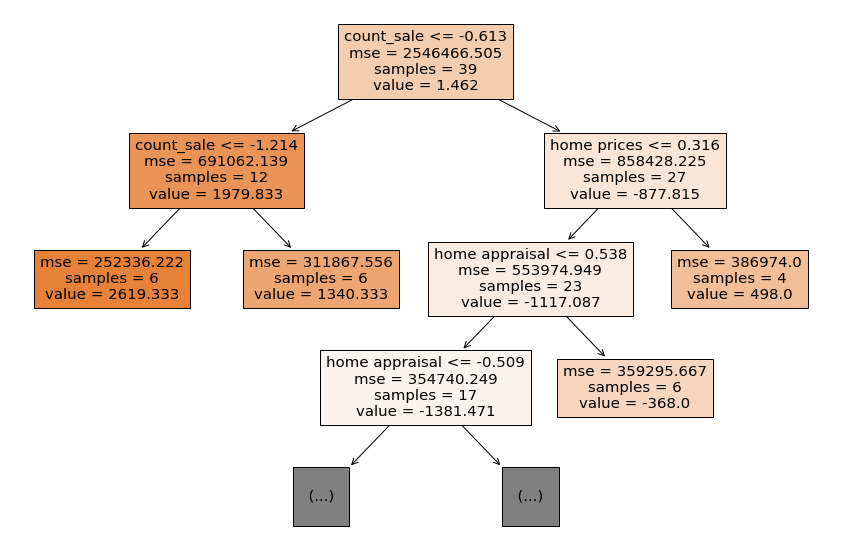

In [1208]:
plt.figure(figsize=(15,10))
tree.plot_tree(model, max_depth = 3,filled=True,feature_names=selected_features_sale)

### Bagging: Random Forest

In [894]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 
          'n_estimators':[5,10,20,30], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=3,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_future'])

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [895]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [1234]:
model = RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_leaf=3,min_samples_split=8)
model.fit(train_X_std, train_y['count_sale_future'])


y_pred_train = model.predict(train_X_std)
y_pred_test = model.predict(test_X_std)


rf_rst = {'r2_train': model.score(train_X_std, train_y['count_sale_future']),
             'r2_test':model.score(test_X_std, test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
rf_rst

{'r2_train': 0.8780369342848918,
 'r2_test': 0.4581743143219612,
 'mse_train': 310574.86168221745,
 'mse_test': 3295241.217191618}

array([0.38737825, 0.55168235, 0.64256044, 0.72938677, 0.81506292,
       0.8432244 , 0.85735794, 0.87062359, 0.88281045, 0.89391999,
       0.90384132, 0.91357875, 0.92260845, 0.93101043, 0.93928793,
       0.94615213, 0.95296869, 0.95972192, 0.9662162 , 0.97255488])

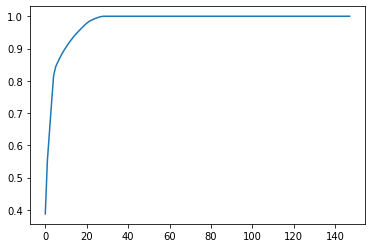

In [1235]:
plt.plot(-np.sort(-model.feature_importances_).cumsum())
-np.sort(-model.feature_importances_).cumsum()[:20]

In [1236]:
selected_features_sale_no_rf = np.argsort(-model.feature_importances_)[:5]

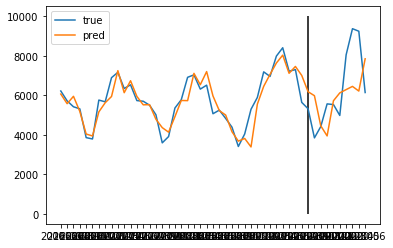

In [1237]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

In [1240]:
model = RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_leaf=4,min_samples_split=8)
model.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_future'])


y_pred_train = model.predict(train_X_std[:,selected_features_sale_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no_rf])


rf1_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_future']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no_rf], test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
rf1_rst

{'r2_train': 0.8313112458280777,
 'r2_test': 0.4275294672387999,
 'mse_train': 429560.2622573341,
 'mse_test': 3481615.111734101}

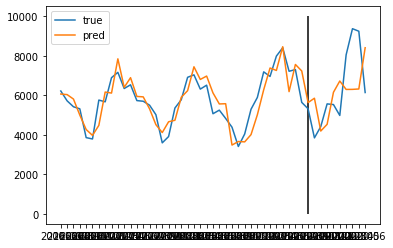

In [1241]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

In [1249]:
model = RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_leaf=4,min_samples_split=8)
model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_future'])


y_pred_train = model.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no])


rf2_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_future']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
rf2_rst

{'r2_train': 0.8658216162925586,
 'r2_test': 0.38361274524932987,
 'mse_train': 341680.7597967745,
 'mse_test': 3748705.0564319976}

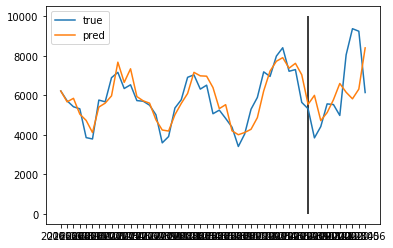

In [1250]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

### Boosting: GBDT

In [996]:
#use grid search to find the params
params = {'learning_rate':[0.1,0.3,0.5,1.],'max_depth':[2,3,5], 'min_samples_leaf':[2,4,6,8], 
          'min_samples_split':[5,10,15],'n_estimators':[5,10,20], 'subsample':[0.3,0.5,1.]}
scores_cv = []

model = GradientBoostingRegressor()
clf = GridSearchCV(model, params,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_future'])

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [997]:
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [1259]:
model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=20, subsample=0.3, 
                                  max_depth=5,min_samples_split=10, min_samples_leaf=4)
model.fit(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_future'])

y_pred_train = model.predict(train_X_std[:,selected_features_sale_no_rf])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no_rf])


gbdt_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no_rf], train_y['count_sale_future']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no_rf], test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
gbdt_rst



{'r2_train': 0.7969042483223839,
 'r2_test': 0.42510715466143023,
 'mse_train': 517176.5289408265,
 'mse_test': 3496346.9793012165}

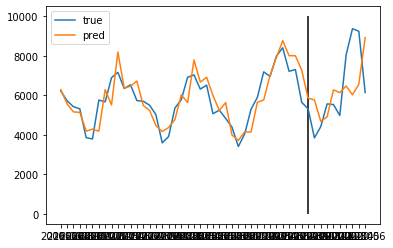

In [1260]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

In [1261]:
#use grid search to find the params
params = {'learning_rate':[0.1,0.3,0.5,1.],'max_depth':[2,3,5], 'min_samples_leaf':[2,4,6,8], 
          'min_samples_split':[5,10,15],'n_estimators':[5,10,20], 'subsample':[0.3,0.5,1.]}
scores_cv = []

model = GradientBoostingRegressor()
clf = GridSearchCV(model, params,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_future'])
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.5, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [1282]:
model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=10, subsample=0.3, 
                                  max_depth=5,min_samples_split=10, min_samples_leaf=2)
model.fit(train_X_std[:,selected_features_sale_no], train_y['count_sale_future'])

y_pred_train = model.predict(train_X_std[:,selected_features_sale_no])
y_pred_test = model.predict(test_X_std[:,selected_features_sale_no])


gbdt1_rst = {'r2_train': model.score(train_X_std[:,selected_features_sale_no], train_y['count_sale_future']),
             'r2_test':model.score(test_X_std[:,selected_features_sale_no], test_y['count_sale_future']),
             'mse_train': mean_squared_error(train_y['count_sale_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_sale_future'],y_pred_test)}
gbdt1_rst

{'r2_train': 0.8254378742864354,
 'r2_test': 0.46001473087576406,
 'mse_train': 444516.60615914094,
 'mse_test': 3284048.288090622}

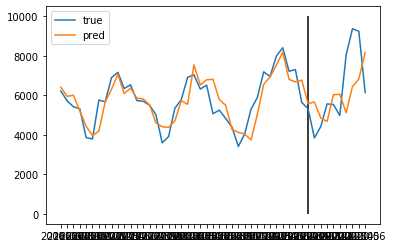

In [1283]:
true_train = monthData['count_sale'].values[3:42]+train_y['count_sale_future']
true_test = monthData['count_sale'].values[42:52]+test_y['count_sale_future']
pred_train = monthData['count_sale'].values[3:42]+y_pred_train
pred_test = monthData['count_sale'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

### Poisson

In [2]:
from statsmodels.formula.api import poisson
#model = poisson(formula = "")

### Comparing

In [1286]:
result = pd.DataFrame(columns=['Lasso','Elastic','Ridge','PCA','KNN', 'Tree1','Tree2','RandomForest','GBDT'])
for i,mod in enumerate([lasso_rst, elastic_rst,ridge_rst,pcalr_rst, knn_rst,tree1_rst,tree2_rst,rf_rst,gbdt_rst]):
    result.iloc[:,i] = pd.Series(mod)

In [1287]:
result

,Lasso,Elastic,Ridge,PCA,KNN,Tree1,Tree2,RandomForest,GBDT
r2_train,9.410124e-01,9.600850e-01,9.590886e-01,1.643903e-01,9.153966e-01,9.405104e-01,8.935717e-01,8.780369e-01,7.969042e-01
r2_test,3.196857e-01,3.574380e-01,3.416441e-01,4.224895e-02,2.444139e-01,3.961690e-01,3.348466e-01,4.581743e-01,4.251072e-01
mse_train,1.502099e+05,1.016422e+05,1.041795e+05,2.127852e+06,2.154396e+05,1.514883e+05,2.710162e+05,3.105749e+05,5.171765e+05
mse_test,4.137493e+06,3.907893e+06,4.003947e+06,5.824790e+06,4.595276e+06,3.672341e+06,4.045288e+06,3.295241e+06,3.496347e+06


The model that has best performance to predict the number of sales is the RandomForest and GBDT model with features selected by Lasso. However, the bagging and boosting models are very sensitive. The result changes every time we fit the model. Thus, Elastic model will be better in this case. 

### 5.2 Predict the count of lists in 3 months

### Lasso Regression

In [1070]:
#First use lasso to decrease the feature dimension
lr = LassoCV()
lr.fit(train_X_std, train_y['count_list_future'])
selected_features_list = feature_column_names[abs(lr.coef_)>0]
selected_features_list_no = abs(lr.coef_)>0
selected_features_list

array(['count_list', 'home values', 'home appraisal',
       'homes for sale in Denver', 'mean_price_diff', 'home value_diff',
       'how much is my house worth_diff3', 'zillow_diff3',
       'homes for sale_diff', 'townhomes for sale_diff3',
       'zillow homes for sale_diff3'], dtype=object)

In [1071]:
y_pred_train = lr.predict(train_X_std)
y_pred_test = lr.predict(test_X_std)

lasso_rst = {'r2_train': lr.score(train_X_std, train_y['count_list_future']),
             'r2_test':lr.score(test_X_std, test_y['count_list_future']),
             'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
lasso_rst

{'r2_train': 0.6475202378923105,
 'r2_test': 0.5695322334098952,
 'mse_train': 7205058.674298441,
 'mse_test': 13910743.01054051}

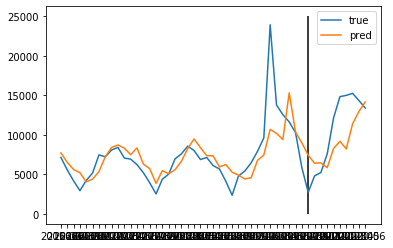

In [1073]:
true_train = monthData['count_list'].values[3:42]+train_y['count_list_future']
true_test = monthData['count_list'].values[42:52]+test_y['count_list_future']
pred_train = monthData['count_list'].values[3:42]+y_pred_train
pred_test = monthData['count_list'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=25000)

### Linear model with regularization terms

In [1074]:
#elastic
lr = sklearn.linear_model.ElasticNetCV()
lr.fit(train_X_std, train_y['count_list_future'])
y_pred_train = lr.predict(train_X_std)
y_pred_test = lr.predict(test_X_std)

elastic_rst = {'r2_train': lr.score(train_X_std, train_y['count_list_future']),
             'r2_test':lr.score(test_X_std, test_y['count_list_future']),
             'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
elastic_rst

{'r2_train': 0.7851573392954603,
 'r2_test': 0.47294472998983117,
 'mse_train': 4391610.930688469,
 'mse_test': 17032007.928351663}

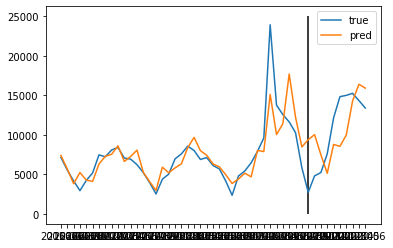

In [1076]:
true_train = monthData['count_list'].values[3:42]+train_y['count_list_future']
true_test = monthData['count_list'].values[42:52]+test_y['count_list_future']
pred_train = monthData['count_list'].values[3:42]+y_pred_train
pred_test = monthData['count_list'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=25000)

In [1077]:
#ridge
lr = sklearn.linear_model.RidgeCV()
lr.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])
y_pred_train = lr.predict(train_X_std[:,selected_features_list_no])
y_pred_test = lr.predict(test_X_std[:,selected_features_list_no])

ridge_rst = {'r2_train': lr.score(train_X_std[:,selected_features_list_no], train_y['count_list_future']),
             'r2_test':lr.score(test_X_std[:,selected_features_list_no], test_y['count_list_future']),
             'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
ridge_rst

{'r2_train': 0.7997408452408288,
 'r2_test': 0.7125694977203645,
 'mse_train': 4093508.664092927,
 'mse_test': 9288434.955943804}

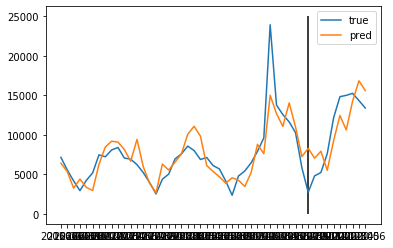

In [1078]:
true_train = monthData['count_list'].values[3:42]+train_y['count_list_future']
true_test = monthData['count_list'].values[42:52]+test_y['count_list_future']
pred_train = monthData['count_list'].values[3:42]+y_pred_train
pred_test = monthData['count_list'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=25000)

In [1165]:
#ridge
lr = sklearn.linear_model.RidgeCV()
lr.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_future'])
y_pred_train = lr.predict(train_X_std[:,selected_features_list_no_rf])
y_pred_test = lr.predict(test_X_std[:,selected_features_list_no_rf])

ridge1_rst = {'r2_train': lr.score(train_X_std[:,selected_features_list_no_rf], train_y['count_list_future']),
             'r2_test':lr.score(test_X_std[:,selected_features_list_no_rf], test_y['count_list_future']),
             'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
ridge1_rst

{'r2_train': 0.46831280137401854,
 'r2_test': 0.4442269133465913,
 'mse_train': 10868247.979874572,
 'mse_test': 17960035.99027233}

### K nearest neighbors

Text(0, 0.5, 'score')

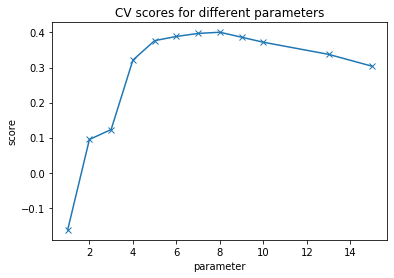

In [1079]:
#using cross validation to find n_neighbors
neighbors = [1,2,3,4,5,6,7,8,9,10,13,15]
scores_cv = []
for n in neighbors:
    knn = KNeighborsRegressor(n_neighbors=n)
    scores_cv.append(cross_val_score(knn, train_X_std[:,selected_features_list_no], train_y['count_list_future'], cv=3).mean())

plt.plot(neighbors,scores_cv,'x-')
plt.title('CV scores for different parameters')
plt.xlabel('parameter')
plt.ylabel('score')

In [1082]:
model_knn = KNeighborsRegressor(n_neighbors=6)
model_knn.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])
y_pred_train = model_knn.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model_knn.predict(test_X_std[:,selected_features_list_no])


knn_rst = {'r2_train': model_knn.score(train_X_std[:,selected_features_list_no], train_y['count_list_future']),
             'r2_test':model_knn.score(test_X_std[:,selected_features_list_no], test_y['count_list_future']),
             'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
knn_rst

{'r2_train': 0.5747473729289956,
 'r2_test': 0.18490130561884133,
 'mse_train': 8692612.906695157,
 'mse_test': 26340249.71388889}

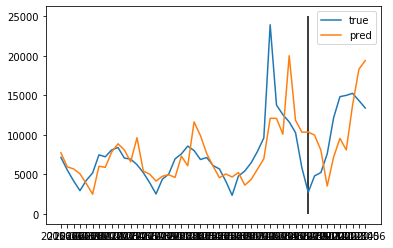

In [1083]:
true_train = monthData['count_list'].values[3:42]+train_y['count_list_future']
true_test = monthData['count_list'].values[42:52]+test_y['count_list_future']
pred_train = monthData['count_list'].values[3:42]+y_pred_train
pred_test = monthData['count_list'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=25000)

### Decision Tree

In [742]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []

model = DecisionTreeRegressor()
clf = GridSearchCV(model, params,cv=3,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])

clf.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [1092]:
model = DecisionTreeRegressor(max_depth=3, min_samples_leaf=4, min_samples_split=4)
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])

y_pred_train = model.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no])


tree1_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_future']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_future']),
             'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
tree1_rst

{'r2_train': 0.7173209275934309,
 'r2_test': 0.22194705252781577,
 'mse_train': 5778258.843874644,
 'mse_test': 25143101.158570986}

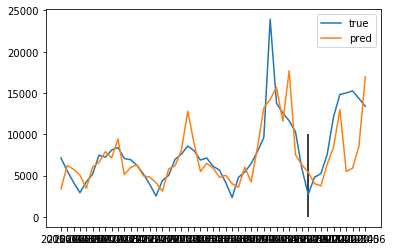

In [1093]:
true_train = monthData['count_list'].values[3:42]+train_y['count_list_future']
true_test = monthData['count_list'].values[42:52]+test_y['count_list_future']
pred_train = monthData['count_list'].values[3:42]+y_pred_train
pred_test = monthData['count_list'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

[Text(494.5909090909091, 475.65000000000003, 'zillow_diff3 <= 1.009\nmse = 20441056.335\nsamples = 39\nvalue = 49.846'),
 Text(304.3636363636364, 339.75, 'count_list <= -0.571\nmse = 11776377.796\nsamples = 31\nvalue = -1191.452'),
 Text(152.1818181818182, 203.85000000000002, 'townhomes for sale_diff3 <= -0.218\nmse = 1786711.136\nsamples = 9\nvalue = 2861.444'),
 Text(76.0909090909091, 67.94999999999999, 'mse = 1678239.5\nsamples = 4\nvalue = 1871.0'),
 Text(228.27272727272728, 67.94999999999999, 'mse = 460876.96\nsamples = 5\nvalue = 3653.8'),
 Text(456.54545454545456, 203.85000000000002, 'count_list <= 0.565\nmse = 6394372.339\nsamples = 22\nvalue = -2849.455'),
 Text(380.4545454545455, 67.94999999999999, 'mse = 1438674.645\nsamples = 18\nvalue = -2095.278'),
 Text(532.6363636363636, 67.94999999999999, 'mse = 14617642.688\nsamples = 4\nvalue = -6243.25'),
 Text(684.8181818181819, 339.75, 'home appraisal <= -0.057\nmse = 24909630.109\nsamples = 8\nvalue = 4859.875'),
 Text(608.727272

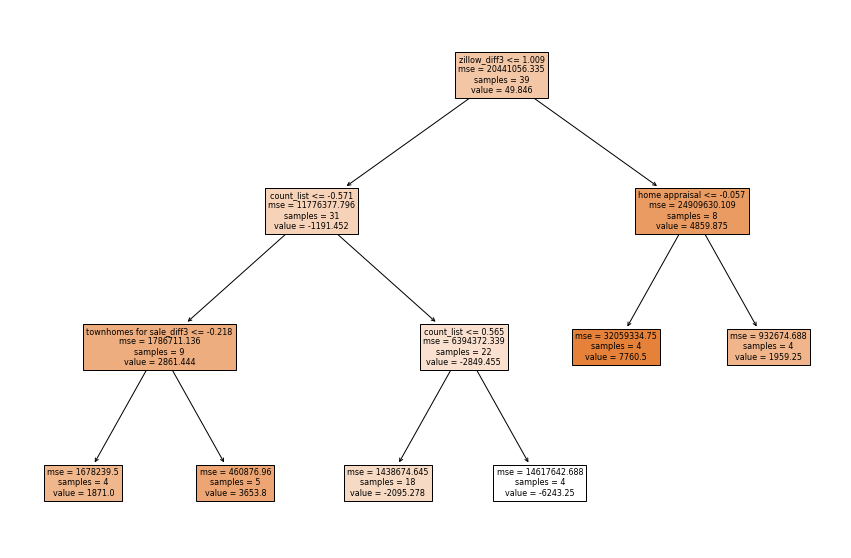

In [1094]:
plt.figure(figsize=(15,10))
tree.plot_tree(model, max_depth = 3,filled=True,feature_names=selected_features_list)

### Random Forest

In [1113]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 
          'n_estimators':[5,10,20,30], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=3,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [1141]:
model = RandomForestRegressor(n_estimators=5, max_depth=3, min_samples_leaf=2,min_samples_split=2)
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])


y_pred_train = model.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no])


rf_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_future']),
        'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_future']),
        'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
        'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
rf_rst

{'r2_train': 0.7843840833124026,
 'r2_test': 0.23004373103529696,
 'mse_train': 4407417.099799764,
 'mse_test': 24881453.660899494}

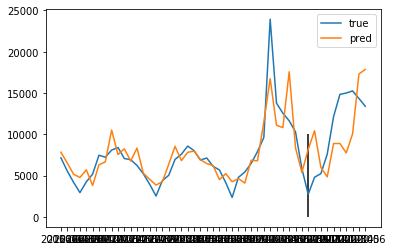

In [1119]:
true_train = monthData['count_list'].values[3:42]+train_y['count_list_future']
true_test = monthData['count_list'].values[42:52]+test_y['count_list_future']
pred_train = monthData['count_list'].values[3:42]+y_pred_train
pred_test = monthData['count_list'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

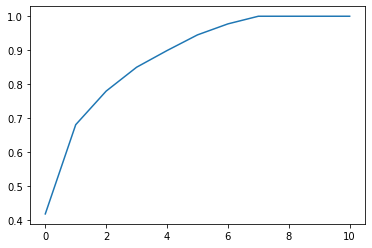

In [1143]:
plt.plot(-np.sort(-model.feature_importances_).cumsum())
-np.sort(-model.feature_importances_).cumsum()[:20]
selected_features_list_no_rf = np.argsort(-model.feature_importances_)[:5]

In [1166]:
#use grid search to find the params
params = {'max_depth':[1,2,3,4,5], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10], 
          'n_estimators':[5,10,20,30], 'min_samples_split':[2,4,6,8,10,13,15]}
scores_cv = []

model = RandomForestRegressor()
clf = GridSearchCV(model, params,cv=3,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_future'])
clf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [1175]:
model = RandomForestRegressor(n_estimators=5, max_depth=5, min_samples_leaf=4,min_samples_split=4)
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])


y_pred_train = model.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no])


rf1_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_future']),
        'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_future']),
        'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
        'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
rf1_rst

{'r2_train': 0.538588154319689,
 'r2_test': 0.3655482693000619,
 'mse_train': 9431745.53132863,
 'mse_test': 20502568.748111166}

### Boosting: GBDT

In [1126]:
#use grid search to find the params
params = {'learning_rate':[0.1,0.3,0.5,1.],'max_depth':[2,3,5], 'min_samples_leaf':[2,4,6,8], 
          'min_samples_split':[5,10,15],'n_estimators':[5,10,20], 'subsample':[0.3,0.5,1.]}
scores_cv = []

model = GradientBoostingRegressor()
clf = GridSearchCV(model, params,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.3, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [1136]:
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=20, subsample=0.5, max_depth=3,min_samples_split=5, min_samples_leaf=2)
model.fit(train_X_std[:,selected_features_list_no], train_y['count_list_future'])

y_pred_train = model.predict(train_X_std[:,selected_features_list_no])
y_pred_test = model.predict(test_X_std[:,selected_features_list_no])


gbdt_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no], train_y['count_list_future']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no], test_y['count_list_future']),
             'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
gbdt_rst




{'r2_train': 0.797740915857032,
 'r2_test': 0.4490406418320677,
 'mse_train': 4134389.33329375,
 'mse_test': 17804478.373463023}

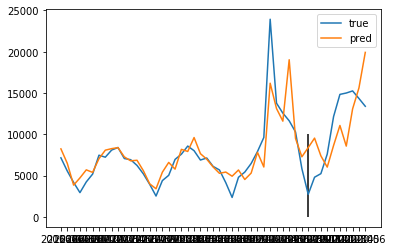

In [1137]:
true_train = monthData['count_list'].values[3:42]+train_y['count_list_future']
true_test = monthData['count_list'].values[42:52]+test_y['count_list_future']
pred_train = monthData['count_list'].values[3:42]+y_pred_train
pred_test = monthData['count_list'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

In [1144]:
#use grid search to find the params
params = {'learning_rate':[0.1,0.3,0.5,1.],'max_depth':[2,3,5], 'min_samples_leaf':[2,4,6,8], 
          'min_samples_split':[5,10,15],'n_estimators':[5,10,20], 'subsample':[0.3,0.5,1.]}
scores_cv = []

model = GradientBoostingRegressor()
clf = GridSearchCV(model, params,scoring='neg_mean_squared_error')
clf.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_future'])
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=8, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=5,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [1162]:
model = GradientBoostingRegressor(learning_rate=1.0, n_estimators=5, subsample=0.5, max_depth=2,min_samples_split=5, min_samples_leaf=8)
model.fit(train_X_std[:,selected_features_list_no_rf], train_y['count_list_future'])

y_pred_train = model.predict(train_X_std[:,selected_features_list_no_rf]
y_pred_test = model.predict(test_X_std[:,selected_features_list_no_rf])


gbdt1_rst = {'r2_train': model.score(train_X_std[:,selected_features_list_no_rf], train_y['count_list_future']),
             'r2_test':model.score(test_X_std[:,selected_features_list_no_rf], test_y['count_list_future']),
             'mse_train': mean_squared_error(train_y['count_list_future'],y_pred_train),
             'mse_test': mean_squared_error(test_y['count_list_future'],y_pred_test)}
gbdt1_rst




{'r2_train': 0.35419593868021715,
 'r2_test': 0.5658680487078113,
 'mse_train': 13200917.199006913,
 'mse_test': 14029152.646963716}

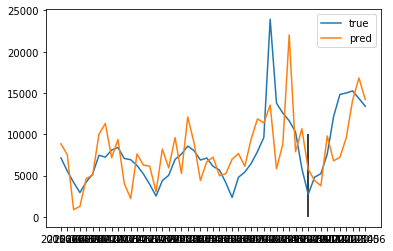

In [1164]:
true_train = monthData['count_list'].values[3:42]+train_y['count_list_future']
true_test = monthData['count_list'].values[42:52]+test_y['count_list_future']
pred_train = monthData['count_list'].values[3:42]+y_pred_train
pred_test = monthData['count_list'].values[42:52]+y_pred_test
plt.plot(monthData.month[3:52], np.append(true_train, true_test), label='true')
plt.plot(monthData.month[3:52], np.append(pred_train, pred_test), label='pred')
plt.legend()
plt.vlines(x=monthData.month[42],ymin=0,ymax=10000)

### Comparing

In [1163]:
result = pd.DataFrame(columns=['Lasso','Elastic','Ridge','KNN', 'Tree1','RandomForest','GBDT','GBDT2'])
for i,mod in enumerate([lasso_rst, elastic_rst,ridge_rst,knn_rst,tree1_rst,rf_rst,gbdt_rst, gbdt1_rst]):
    result.iloc[:,i] = pd.Series(mod)
result

,Lasso,Elastic,Ridge,KNN,Tree1,RandomForest,GBDT,GBDT2
r2_train,6.475202e-01,7.851573e-01,7.997408e-01,5.747474e-01,7.173209e-01,7.843841e-01,7.977409e-01,3.541959e-01
r2_test,5.695322e-01,4.729447e-01,7.125695e-01,1.849013e-01,2.219471e-01,2.300437e-01,4.490406e-01,5.658680e-01
mse_train,7.205059e+06,4.391611e+06,4.093509e+06,8.692613e+06,5.778259e+06,4.407417e+06,4.134389e+06,1.320092e+07
mse_test,1.391074e+07,1.703201e+07,9.288435e+06,2.634025e+07,2.514310e+07,2.488145e+07,1.780448e+07,1.402915e+07


The model with best performance to predict number of new listings is Ridge regression with features selected by Lasso.